In [2]:
import pandas as pd
import numpy as np

In [257]:
df = pd.read_csv("/Users/tobifadeyi/Documents/Thesis code/Raw Data/FTSE Combined with scores/combined_all_with_scores.csv")

In [61]:
missing_100 = df.columns[df.isnull().mean() == 1.0]
print(f"Number of columns with 100% missingness: {len(missing_100)}")
missing_100

Number of columns with 100% missingness: 87


Index(['Fleet Fuel Consumption_x', 'Lobbying Controversies',
       'Lobbying Contribution Amount', 'Recent Public Health Controversies',
       'Recent Critical Countries Controversies',
       'Military Weapons or Personnel Revenue', 'Firearms Producer Revenue',
       'Firearms Retailer Revenue', 'Alcohol Retailer Revenue',
       'Tobacco Retailer Revenue',
       'Military Weapons or Personnel Revenue Percent',
       'Firearms Producer Revenue Percent', 'Gambling Retailer Revenue',
       'Firearms Retailer Revenue Percent',
       'Thermal Coal-fired Power Generation Revenue',
       'Alcohol Retailer Revenue Percent', 'Nuclear Power Generation Revenue',
       'Tobacco Retailer Revenue Percent', 'Gambling Retailer Revenue Percent',
       'Oil Sands Producer Revenue',
       'Thermal Coal-fired Power Generation Revenue Percent',
       'Nuclear Power Generation Revenue Percent',
       'Arctic Oil Producer Revenue', 'Oil Sands Producer Revenue Percent',
       'Arctic Oil Produ

In [258]:
df = df.drop(columns=missing_100, errors='ignore')

In [259]:
gov_path = "/Users/tobifadeyi/Documents/Thesis code/Raw Data/FTSE Combined Data sets/extracted_governance_full.csv"
soc_path = "/Users/tobifadeyi/Documents/Thesis code/Raw Data/FTSE Combined Data sets/extracted_social_full.csv"
env_path = "/Users/tobifadeyi/Documents/Thesis code/Raw Data/FTSE Combined Data sets/extracted_environment_full.csv"


In [261]:
governance = pd.read_csv(gov_path)
social = pd.read_csv(soc_path)
environment = pd.read_csv(env_path)

gov_cols = list(governance.columns)
soc_cols = list(social.columns)
env_cols = list(environment.columns)

# Combine all columns (remove duplicates)
all_cols = list(dict.fromkeys(gov_cols + soc_cols + env_cols))

# Select these columns from df (if they exist)
cols_in_df = [col for col in all_cols if col in df.columns]
merged = df[cols_in_df]


In [262]:
# Split the tab-separated string into a list of column names
cols_to_drop = [
	'ESG Score Grade_x', 'ESG Combined Score Grade_x', 'ESG Score_x', 'ESG Combined Score_x', 'ESG Controversies Score_x',
	'Social Pillar Score Grade_x', 'Governance Pillar Score Grade_x', 'Environmental Pillar Score Grade_x',
	'Social Pillar Score_x', 'Governance Pillar Score_x', 'Environmental Pillar Score_x',
	'Resource Use Score Grade_x', 'Emissions Score Grade_x', 'Environmental Innovation Score Grade_x',
	'Workforce Score Grade_x', 'Human Rights Score Grade_x', 'Community Score Grade_x',
	'Product Responsibility Score Grade_x', 'Management Score Grade_x', 'Shareholders Score Grade_x',
	'CSR Strategy Score Grade_x', 'Resource Use Score_x', 'Emissions Score_x', 'Environmental Innovation Score_x',
	'Workforce Score_x', 'Human Rights Score_x', 'Community Score_x', 'Product Responsibility Score_x',
	'Management Score_x', 'Shareholders Score_x', 'CSR Strategy Score_x', 'Instrument',
]
merged.drop(columns=cols_to_drop, inplace=True, errors='ignore')

/var/folders/fl/lv0hc01x58s_68_8g3k5dngc0000gn/T/ipykernel_6891/1482731155.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged.drop(columns=cols_to_drop, inplace=True, errors='ignore')


In [263]:
merged.drop_duplicates(inplace=True)

/var/folders/fl/lv0hc01x58s_68_8g3k5dngc0000gn/T/ipykernel_6891/3747040622.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged.drop_duplicates(inplace=True)


In [264]:
merged = merged.drop('Instrument', axis=1, errors='ignore')

In [265]:
merged_table = merged.copy()

In [272]:
def robust_bool_to_numeric(series):
    """
    Converts a pandas Series with boolean-like values to 1/0, leaves others unchanged.
    """
    mapping = {
        'true': 1, '1': 1, 'yes': 1, True: 1,
        'false': 0, '0': 0, 'no': 0, False: 0
        , 'No': 0, 'NO': 0, 'Yes': 1, 'YES': 1
    }
    return series.apply(lambda x: mapping.get(str(x).strip().lower(), x) if pd.notnull(x) else x)

for col in merged_table.columns:
    unique = set(str(x).strip().lower() for x in merged_table[col].dropna().unique())
    # Only convert if column contains *only* these values (and NaN)
    if unique <= {'true','false','1','0','yes','no','No','NO','Yes','YES', True, False}:
        merged_table[col] = robust_bool_to_numeric(merged_table[col])



In [268]:
percent_map = {
    '100%': 1.0,
    '>50% to 100%': 0.75,
    '>20% to 50%': 0.35,
    '>10% to 20%': 0.15,
    '0 to 10%': 0.05,
    '>10% to 20%': 0.15,
    '>20% to 50%': 0.35,
    '>50% to 100%': 0.75,
    # add other mappings as needed
}

for col in merged_table.columns:
    if set(str(x).strip() for x in merged_table[col].dropna().unique()).issubset(percent_map.keys()):
        merged_table[col] = merged_table[col].map(percent_map)


In [273]:
merged_table.select_dtypes(include='object').columns.tolist()

['CSR Sustainability External Auditor Name',
 'ESG Period Last Update Date',
 'Critical Country 1',
 'Critical Country 2',
 'Critical Country 3',
 'Critical Country 4',
 'Critical Country 5',
 'CO2 Estimation Method',
 'ISO 14000 or EMS']

In [277]:
possible_categorical = merged_table.select_dtypes(include='object').nunique()

In [283]:
cat_cols = possible_categorical[possible_categorical <= 100].index

In [284]:
for col in cat_cols:
	print(f"{col}: {merged_table[col].unique()}")

Critical Country 1: [nan 'CU' 'SD']
Critical Country 2: [nan 'IR']
Critical Country 3: [nan 'MM']
Critical Country 4: [nan 'SD']
Critical Country 5: [nan 'IR']
CO2 Estimation Method: [nan 'Median' 'Reported']
ISO 14000 or EMS: [nan 'No' 'ISO 14000' 'Both' 'EMS']


In [275]:
merged_table.loc[:, merged.dtypes == 'object']

Audit Oversight of Tax  Named Position for Tax Oversight  \
0                       NaN                               NaN   
1                       NaN                               NaN   
2                       NaN                               NaN   
3                       0.0                               0.0   
4                       0.0                               0.0   
..                      ...                               ...   
514                     NaN                               NaN   
515                     NaN                               NaN   
516                     0.0                               0.0   
517                     0.0                               0.0   
518                     0.0                               0.0   

     Tax Breakdown by Country  Tax Breakdown by Domestic or International  \
0                         NaN                                         NaN   
1                         NaN                                         NaN   
2                         NaN                                         NaN   
3                         0.0                                         0.0   
4                         0.0                                         0.0   
..                        ...                                         ...   
514                       NaN                                         NaN   
515                       NaN                                         NaN   
516                       0.0                                         0.0   
517                       0.0                                         0.0   
518                       0.0                                         0.0   

     Tax Data Verification  Tax Fairness Commitment  Tax in Audit Tor  \
0                      NaN                      NaN               NaN   
1                      NaN                      NaN               NaN   
2                      NaN                      NaN               NaN   
3                      0.0                      0.0               0.0   
4                      0.0                      0.0               0.0   
..                     ...                      ...               ...   
514                    NaN                      NaN               NaN   
515                    NaN                      NaN               NaN   
516                    0.0                      0.0               0.0   
517                    0.0                      0.0               0.0   
518                    0.0                      0.0               0.0   

     Tax Oversight by Board  Policy Tax Transparency  Taxes Align to Revenues  \
0                       NaN                      NaN                      NaN   
1                       NaN                      NaN                      NaN   
2                       NaN                      NaN                      NaN   
3                       0.0                      0.0                      0.0   
4                       0.0                      0.0                      0.0   
..                      ...                      ...                      ...   
514                     NaN                      NaN                      NaN   
515                     NaN                      NaN                      NaN   
516                     0.0                      0.0                      0.0   
517                     0.0                      0.0                      0.0   
518                     0.0                      0.0                      0.0   

     ...  CO2 Estimation Method  Particulate Matter Emissions Reduction  \
0    ...                    NaN                                     NaN   
1    ...                 Median                                     0.0   
2    ...                 Median                                     0.0   
3    ...               Reported                                     0.0   
4    ...               Reported                                     0.0   

In [229]:
merged_table

Audit Oversight of Tax  Named Position for Tax Oversight  \
0                       NaN                               NaN   
1                       NaN                               NaN   
2                       NaN                               NaN   
3                       0.0                               0.0   
4                       0.0                               0.0   
..                      ...                               ...   
514                     NaN                               NaN   
515                     NaN                               NaN   
516                     0.0                               0.0   
517                     0.0                               0.0   
518                     0.0                               0.0   

     Tax Breakdown by Country  Tax Breakdown by Domestic or International  \
0                         NaN                                         NaN   
1                         NaN                                         NaN   
2                         NaN                                         NaN   
3                         0.0                                         0.0   
4                         0.0                                         0.0   
..                        ...                                         ...   
514                       NaN                                         NaN   
515                       NaN                                         NaN   
516                       0.0                                         0.0   
517                       0.0                                         0.0   
518                       0.0                                         0.0   

     Tax Data Verification  Tax Fairness Commitment  Tax in Audit Tor  \
0                      NaN                      NaN               NaN   
1                      NaN                      NaN               NaN   
2                      NaN                      NaN               NaN   
3                      0.0                      0.0               0.0   
4                      0.0                      0.0               0.0   
..                     ...                      ...               ...   
514                    NaN                      NaN               NaN   
515                    NaN                      NaN               NaN   
516                    0.0                      0.0               0.0   
517                    0.0                      0.0               0.0   
518                    0.0                      0.0               0.0   

     Tax Oversight by Board  Policy Tax Transparency  Taxes Align to Revenues  \
0                       NaN                      NaN                      NaN   
1                       NaN                      NaN                      NaN   
2                       NaN                      NaN                      NaN   
3                       0.0                      0.0                      0.0   
4                       0.0                      0.0                      0.0   
..                      ...                      ...                      ...   
514                     NaN                      NaN                      NaN   
515                     NaN                      NaN                      NaN   
516                     0.0                      0.0                      0.0   
517                     0.0                      0.0                      0.0   
518                     0.0                      0.0                      0.0   

     ...  Self-Reported Environmental Fines To Revenues in million  \
0    ...                                                NaN          
1    ...                                                NaN          
2    ...                                                NaN          
3    ...                                                NaN          
4    ...                                                NaN          
..   ...                     

In [164]:
pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')
pd.reset_option('display.max_colwidth')


In [278]:
# Select columns with 10 or fewer unique values (likely categorical)
cat_cols = possible_categorical[possible_categorical <= 100].index
merged_table.loc[:, cat_cols]

CSR Sustainability External Auditor Name ESG Period Last Update Date  \
0                                        NaN                         NaN   
1                                        NaN                  2025-05-30   
2                                        NaN                  2025-05-30   
3                                        NaN                  2025-06-20   
4                                        NaN                  2025-06-20   
..                                       ...                         ...   
514                    Corporate Citizenship                  2025-02-28   
515                    Corporate Citizenship                  2025-06-06   
516                    Corporate Citizenship                  2025-06-20   
517                         RSM UK Audit LLP                  2025-07-25   
518                         RSM UK Audit LLP                  2025-07-25   

    Critical Country 1 Critical Country 2 Critical Country 3  \
0                  NaN                NaN                NaN   
1                  NaN                NaN                NaN   
2                  NaN                NaN                NaN   
3                  NaN                NaN                NaN   
4                  NaN                NaN                NaN   
..                 ...                ...                ...   
514                NaN                NaN                NaN   
515                NaN                NaN                NaN   
516                NaN                NaN                NaN   
517                NaN                NaN                NaN   
518                NaN                NaN                NaN   

    Critical Country 4 Critical Country 5 CO2 Estimation Method  \
0                  NaN                NaN                   NaN   
1                  NaN                NaN                Median   
2                  NaN                NaN                Median   
3                  NaN                NaN              Reported   
4                  NaN                NaN              Reported   
..                 ...                ...                   ...   
514                NaN                NaN              Reported   
515                NaN                NaN              Reported   
516                NaN                NaN              Reported   
517                NaN                NaN              Reported   
518                NaN                NaN              Reported   

    ISO 14000 or EMS  
0                NaN  
1                 No  
2                 No  
3                 No  
4                 No  
..               ...  
514               No  
515               No  
516               No  
517               No  
518               No  

[479 rows x 9 columns]

In [279]:
merged.drop(columns=['ESG Period Last Update Date'], inplace=True, errors='ignore')
merged_table.drop(columns=['ESG Period Last Update Date'], inplace=True, errors='ignore')
merged_table.drop(columns=['CSR Sustainability External Auditor Name'], inplace=True, errors='ignore')
merged.drop(columns=['CSR Sustainability External Auditor Name'], inplace=True, errors='ignore')  

In [281]:
possible_categorical = merged_table.select_dtypes(include='object').nunique()
cat_cols = possible_categorical[possible_categorical <= 100].index
merged_table.loc[:, cat_cols]

Critical Country 1 Critical Country 2 Critical Country 3  \
0                  NaN                NaN                NaN   
1                  NaN                NaN                NaN   
2                  NaN                NaN                NaN   
3                  NaN                NaN                NaN   
4                  NaN                NaN                NaN   
..                 ...                ...                ...   
514                NaN                NaN                NaN   
515                NaN                NaN                NaN   
516                NaN                NaN                NaN   
517                NaN                NaN                NaN   
518                NaN                NaN                NaN   

    Critical Country 4 Critical Country 5 CO2 Estimation Method  \
0                  NaN                NaN                   NaN   
1                  NaN                NaN                Median   
2                  NaN                NaN                Median   
3                  NaN                NaN              Reported   
4                  NaN                NaN              Reported   
..                 ...                ...                   ...   
514                NaN                NaN              Reported   
515                NaN                NaN              Reported   
516                NaN                NaN              Reported   
517                NaN                NaN              Reported   
518                NaN                NaN              Reported   

    ISO 14000 or EMS  
0                NaN  
1                 No  
2                 No  
3                 No  
4                 No  
..               ...  
514               No  
515               No  
516               No  
517               No  
518               No  

[479 rows x 7 columns]

In [285]:
merged_table

Audit Oversight of Tax  Named Position for Tax Oversight  \
0                       NaN                               NaN   
1                       NaN                               NaN   
2                       NaN                               NaN   
3                       0.0                               0.0   
4                       0.0                               0.0   
..                      ...                               ...   
514                     NaN                               NaN   
515                     NaN                               NaN   
516                     0.0                               0.0   
517                     0.0                               0.0   
518                     0.0                               0.0   

     Tax Breakdown by Country  Tax Breakdown by Domestic or International  \
0                         NaN                                         NaN   
1                         NaN                                         NaN   
2                         NaN                                         NaN   
3                         0.0                                         0.0   
4                         0.0                                         0.0   
..                        ...                                         ...   
514                       NaN                                         NaN   
515                       NaN                                         NaN   
516                       0.0                                         0.0   
517                       0.0                                         0.0   
518                       0.0                                         0.0   

     Tax Data Verification  Tax Fairness Commitment  Tax in Audit Tor  \
0                      NaN                      NaN               NaN   
1                      NaN                      NaN               NaN   
2                      NaN                      NaN               NaN   
3                      0.0                      0.0               0.0   
4                      0.0                      0.0               0.0   
..                     ...                      ...               ...   
514                    NaN                      NaN               NaN   
515                    NaN                      NaN               NaN   
516                    0.0                      0.0               0.0   
517                    0.0                      0.0               0.0   
518                    0.0                      0.0               0.0   

     Tax Oversight by Board  Policy Tax Transparency  Taxes Align to Revenues  \
0                       NaN                      NaN                      NaN   
1                       NaN                      NaN                      NaN   
2                       NaN                      NaN                      NaN   
3                       0.0                      0.0                      0.0   
4                       0.0                      0.0                      0.0   
..                      ...                      ...                      ...   
514                     NaN                      NaN                      NaN   
515                     NaN                      NaN                      NaN   
516                     0.0                      0.0                      0.0   
517                     0.0                      0.0                      0.0   
518                     0.0                      0.0                      0.0   

     ...  Self-Reported Environmental Fines To Revenues in million  \
0    ...                                                NaN          
1    ...                                                NaN          
2    ...                                                NaN          
3    ...                                                NaN          
4    ...                                                NaN          
..   ...                     

In [67]:
feature_cols = [col for col in df.columns if col not in exclude_cols]

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

In [286]:
missing_100_merged = merged.columns[merged.isnull().mean() == 1.0]
print(f"Number of columns with 100% missingness in merged: {len(missing_100_merged)}")
missing_100_merged

Number of columns with 100% missingness in merged: 0


Index([], dtype='object')

In [342]:
cleaned_merged = merged_table.copy()

In [320]:
# # 1. Remove features with >80% missing values
# missing_threshold = 0.8
# keep_cols = [col for col in cleaned_merged.columns if cleaned_merged[col].isnull().mean() < missing_threshold]
# filtered_table = cleaned_merged[keep_cols]

# print(f"Columns removed due to missingness: {set(cleaned_merged.columns) - set(filtered_table.columns)}")

# # 2. Remove features with low variance (all values the same, or only one unique non-null value)
# low_variance_cols = [col for col in filtered_table.columns if filtered_table[col].nunique(dropna=True) <= 1]
# filtered_table = filtered_table.drop(columns=low_variance_cols)

# print(f"Columns removed due to low variance: {low_variance_cols}")

# # Now filtered_table contains only features with reasonable data and some variation.


Columns removed due to missingness: {'Recent Tax Fraud Controversies', 'NOx Emissions', 'White - Ethnic Minorities Board Percentage_x', 'Controversies Customer Health & Safety', 'Recent Mgt Compensation Controversies_y', 'Customer Satisfaction', 'Oil and Gas Producer Revenue Percent', 'Tobacco Producer Revenue', 'Water Stressed Sites', 'Military Weapons or Personnel Ownership Percent', 'Targets Board Diversity Percent', 'SOx Emissions', 'Training Costs Total', 'Training Costs Per Employee', 'NOx Emissions To EVIC USD in million', 'Recent Wages Working Condition Controversies', 'Renewable Energy Supply', 'Oil and Gas Producer Ownership Percent', 'Ethnic Minorities Salary Gap', 'Targets Board Diversity - Target Year', 'Contractor Lost Working Days', 'Flaring Gases To EVIC USD in million', 'Self-Reported Environmental Fines To Revenues in million', 'Alcohol Revenues', 'Lost Days To Total Days', 'FDA Warning Letters', 'Emission Controversies Count', 'VOC Emissions To Revenues USD in millio

In [ ]:
# ESG Score	ESG Combined Score	ESG Controversies Score	Social Pillar Score Grade	Governance Pillar Score Grade	Environmental Pillar Score Grade	Social Pillar Score	Governance Pillar Score	Environmental Pillar Score	Resource Use Score Grade	Emissions Score Grade	Environmental Innovation Score Grade	Workforce Score Grade	Human Rights Score Grade	Community Score Grade	Product Responsibility Score Grade	Management Score Grade	Shareholders Score Grade	CSR Strategy Score Grade	Resource Use Score	Emissions Score	Environmental Innovation Score	Workforce Score	Human Rights Score	Community Score	Product Responsibility Score	Management Score	Shareholders Score	CSR Strategy Score

In [343]:
# Reindex merged_table to match df if needed
cleaned_merged = merged_table.reindex(df.index)
for col in ['Social Pillar Score', 'Governance Pillar Score', 'Environmental Pillar Score']:
    if col in df.columns:
        merged_table[col] = df[col]


In [344]:
keep_clean = cleaned_merged.copy()

In [345]:
cleaned_merged = pd.get_dummies(cleaned_merged, columns=cat_cols, dummy_na=True, drop_first=False)

In [346]:
cleaned_merged

Audit Oversight of Tax  Named Position for Tax Oversight  \
0                       NaN                               NaN   
1                       NaN                               NaN   
2                       NaN                               NaN   
3                       0.0                               0.0   
4                       0.0                               0.0   
..                      ...                               ...   
514                     NaN                               NaN   
515                     NaN                               NaN   
516                     0.0                               0.0   
517                     0.0                               0.0   
518                     0.0                               0.0   

     Tax Breakdown by Country  Tax Breakdown by Domestic or International  \
0                         NaN                                         NaN   
1                         NaN                                         NaN   
2                         NaN                                         NaN   
3                         0.0                                         0.0   
4                         0.0                                         0.0   
..                        ...                                         ...   
514                       NaN                                         NaN   
515                       NaN                                         NaN   
516                       0.0                                         0.0   
517                       0.0                                         0.0   
518                       0.0                                         0.0   

     Tax Data Verification  Tax Fairness Commitment  Tax in Audit Tor  \
0                      NaN                      NaN               NaN   
1                      NaN                      NaN               NaN   
2                      NaN                      NaN               NaN   
3                      0.0                      0.0               0.0   
4                      0.0                      0.0               0.0   
..                     ...                      ...               ...   
514                    NaN                      NaN               NaN   
515                    NaN                      NaN               NaN   
516                    0.0                      0.0               0.0   
517                    0.0                      0.0               0.0   
518                    0.0                      0.0               0.0   

     Tax Oversight by Board  Policy Tax Transparency  Taxes Align to Revenues  \
0                       NaN                      NaN                      NaN   
1                       NaN                      NaN                      NaN   
2                       NaN                      NaN                      NaN   
3                       0.0                      0.0                      0.0   
4                       0.0                      0.0                      0.0   
..                      ...                      ...                      ...   
514                     NaN                      NaN                      NaN   
515                     NaN                      NaN                      NaN   
516                     0.0                      0.0                      0.0   
517                     0.0                      0.0                      0.0   
518                     0.0                      0.0                      0.0   

     ...  Critical Country 5_IR  Critical Country 5_nan  \
0    ...                  False                    True   
1    ...                  False                    True   
2    ...                  False                    True   
3    ...                  False                    True   
4    ...                  False                    True   
..   ...                    ...                     ...   
514  ...                  False     

In [347]:
bool_cols = cleaned_merged.select_dtypes(include=['bool']).columns
cleaned_merged[bool_cols] = cleaned_merged[bool_cols].astype(int)


In [348]:
gov_features = [col for col in governance if col in cleaned_merged.columns]
soc_features = [col for col in social if col in cleaned_merged.columns]
env_features = [col for col in environment if col in cleaned_merged.columns]

target_cols = {
    'Governance Pillar Score': gov_features,
    'Social Pillar Score': soc_features,
    'Environmental Pillar Score': env_features
}

corr_results = {}

for target, feats in target_cols.items():
    corr_dict = {}
    for feat in feats:
        # Only use numeric features
        if pd.api.types.is_numeric_dtype(cleaned_merged[feat]):
            valid = cleaned_merged[[feat, target]].dropna()
            if len(valid) > 2:
                corr_dict[feat] = valid[feat].corr(valid[target])
            else:
                corr_dict[feat] = np.nan
    corr_results[target] = pd.Series(corr_dict)

/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2897: RuntimeWarn

In [349]:
corr_threshold = 0.2  # or stricter if you want

imputed_table = cleaned_merged.copy()

for target, feats in target_cols.items():
    corr_series = corr_results[target]
    for feat in feats:
        if pd.api.types.is_numeric_dtype(imputed_table[feat]):
            corr = corr_series.get(feat, np.nan)
            missing_count = imputed_table[feat].isna().sum()
            if pd.isna(corr) or missing_count == 0:
                continue  # skip if no correlation or nothing missing
            if abs(corr) >= corr_threshold:
                fill_val = imputed_table[feat].min() if corr > 0 else imputed_table[feat].max()
                imputed_table[feat] = imputed_table[feat].fillna(fill_val)
                print(f"{feat}: filled {missing_count} missing with {'min' if corr > 0 else 'max'} ({fill_val}) [corr={corr:.2f}]")
            else:
                fill_val = imputed_table[feat].median()
                imputed_table[feat] = imputed_table[feat].fillna(fill_val)
                print(f"{feat}: filled {missing_count} missing with median ({fill_val}) [corr={corr:.2f}, weak or undefined]")


Audit Oversight of Tax: filled 204 missing with min (0.0) [corr=0.28]
Named Position for Tax Oversight: filled 204 missing with median (0.0) [corr=0.19, weak or undefined]
Tax Breakdown by Country: filled 204 missing with min (0.0) [corr=0.28]
Tax Breakdown by Domestic or International: filled 204 missing with min (0.0) [corr=0.30]
Tax Data Verification: filled 204 missing with median (0.0) [corr=0.17, weak or undefined]
Tax Fairness Commitment: filled 204 missing with median (0.0) [corr=0.19, weak or undefined]
Tax in Audit Tor: filled 204 missing with median (0.0) [corr=0.13, weak or undefined]
Tax Oversight by Board: filled 204 missing with min (0.0) [corr=0.29]
Policy Tax Transparency: filled 204 missing with min (0.0) [corr=0.40]
Taxes Align to Revenues: filled 204 missing with min (0.0) [corr=0.38]
CSR Sustainability Committee: filled 44 missing with min (0.0) [corr=0.51]
Integrated Strategy in MD&A: filled 52 missing with median (1.0) [corr=0.02, weak or undefined]
Global Compac

In [353]:
imputed_table

Audit Oversight of Tax  Named Position for Tax Oversight  \
0                       0.0                               0.0   
1                       0.0                               0.0   
2                       0.0                               0.0   
3                       0.0                               0.0   
4                       0.0                               0.0   
..                      ...                               ...   
514                     0.0                               0.0   
515                     0.0                               0.0   
516                     0.0                               0.0   
517                     0.0                               0.0   
518                     0.0                               0.0   

     Tax Breakdown by Country  Tax Breakdown by Domestic or International  \
0                         0.0                                         0.0   
1                         0.0                                         0.0   
2                         0.0                                         0.0   
3                         0.0                                         0.0   
4                         0.0                                         0.0   
..                        ...                                         ...   
514                       0.0                                         0.0   
515                       0.0                                         0.0   
516                       0.0                                         0.0   
517                       0.0                                         0.0   
518                       0.0                                         0.0   

     Tax Data Verification  Tax Fairness Commitment  Tax in Audit Tor  \
0                      0.0                      0.0               0.0   
1                      0.0                      0.0               0.0   
2                      0.0                      0.0               0.0   
3                      0.0                      0.0               0.0   
4                      0.0                      0.0               0.0   
..                     ...                      ...               ...   
514                    0.0                      0.0               0.0   
515                    0.0                      0.0               0.0   
516                    0.0                      0.0               0.0   
517                    0.0                      0.0               0.0   
518                    0.0                      0.0               0.0   

     Tax Oversight by Board  Policy Tax Transparency  Taxes Align to Revenues  \
0                       0.0                      0.0                      0.0   
1                       0.0                      0.0                      0.0   
2                       0.0                      0.0                      0.0   
3                       0.0                      0.0                      0.0   
4                       0.0                      0.0                      0.0   
..                      ...                      ...                      ...   
514                     0.0                      0.0                      0.0   
515                     0.0                      0.0                      0.0   
516                     0.0                      0.0                      0.0   
517                     0.0                      0.0                      0.0   
518                     0.0                      0.0                      0.0   

     ...  Critical Country 5_IR  Critical Country 5_nan  \
0    ...                      0                       1   
1    ...                      0                       1   
2    ...                      0                       1   
3    ...                      0                       1   
4    ...                      0                       1   
..   ...                    ...                     ...   
514  ...                      0     

/var/folders/fl/lv0hc01x58s_68_8g3k5dngc0000gn/T/ipykernel_6891/2292044580.py:48: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


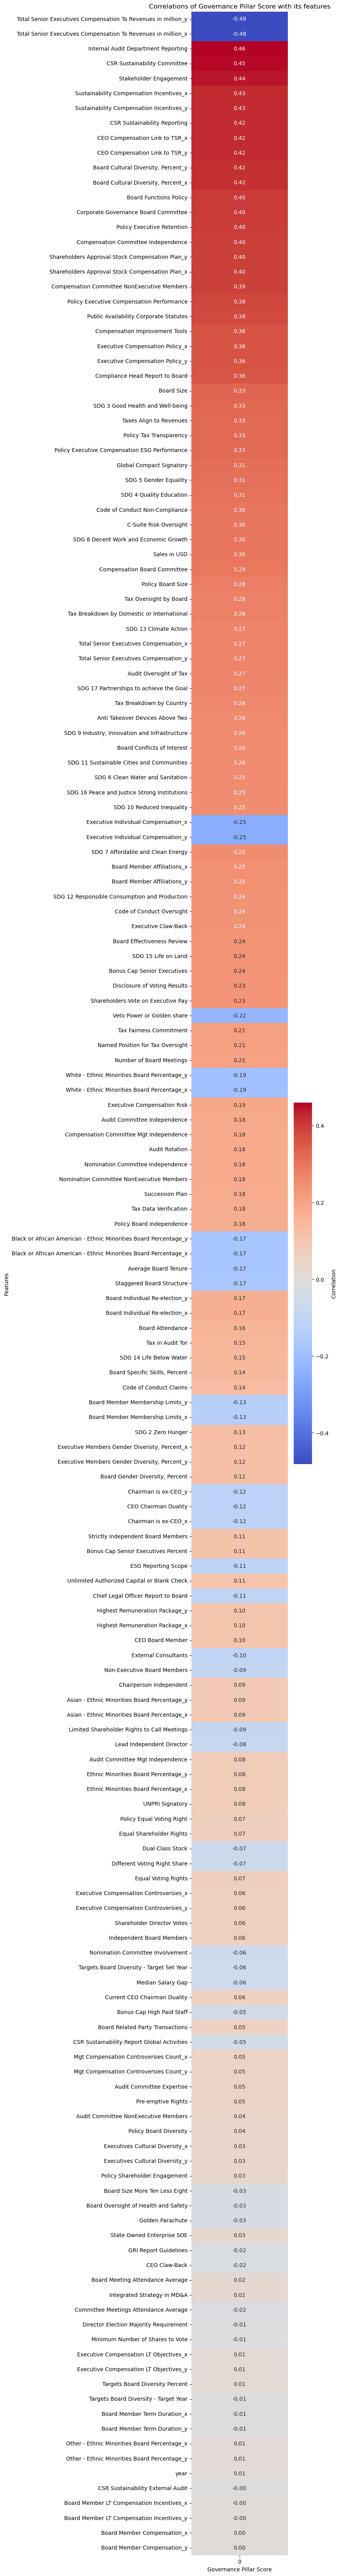


Top 10 features for Governance Pillar Score:
Total Senior Executives Compensation To Revenues in million_y   -0.481741
Total Senior Executives Compensation To Revenues in million_x   -0.481741
Internal Audit Department Reporting                              0.459904
CSR Sustainability Committee                                     0.452568
Stakeholder Engagement                                           0.442660
Sustainability Compensation Incentives_x                         0.425638
Sustainability Compensation Incentives_y                         0.425638
CSR Sustainability Reporting                                     0.424621
CEO Compensation Link to TSR_x                                   0.424134
CEO Compensation Link to TSR_y                                   0.424134
dtype: float64


/var/folders/fl/lv0hc01x58s_68_8g3k5dngc0000gn/T/ipykernel_6891/2292044580.py:48: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


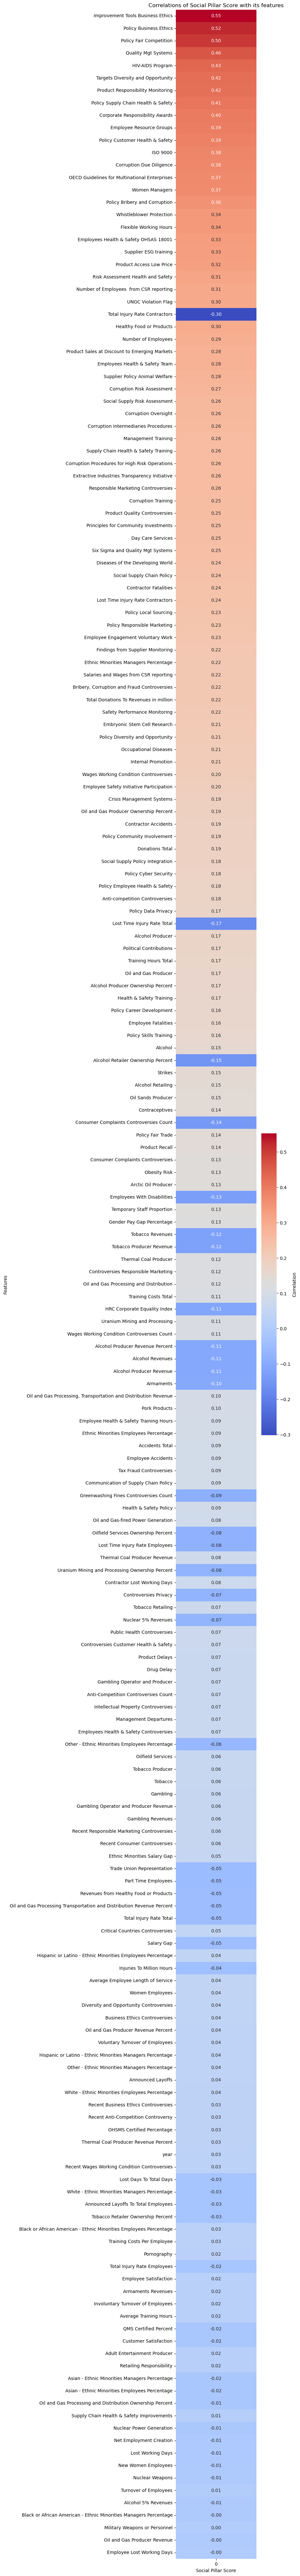


Top 10 features for Social Pillar Score:
Improvement Tools Business Ethics      0.552534
Policy Business Ethics                 0.523343
Policy Fair Competition                0.504695
Quality Mgt Systems                    0.462418
HIV-AIDS Program                       0.434223
Targets Diversity and Opportunity      0.421706
Product Responsibility Monitoring      0.417481
Policy Supply Chain Health & Safety    0.408227
Corporate Responsibility Awards        0.398625
Employee Resource Groups               0.394210
dtype: float64


/var/folders/fl/lv0hc01x58s_68_8g3k5dngc0000gn/T/ipykernel_6891/2292044580.py:48: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


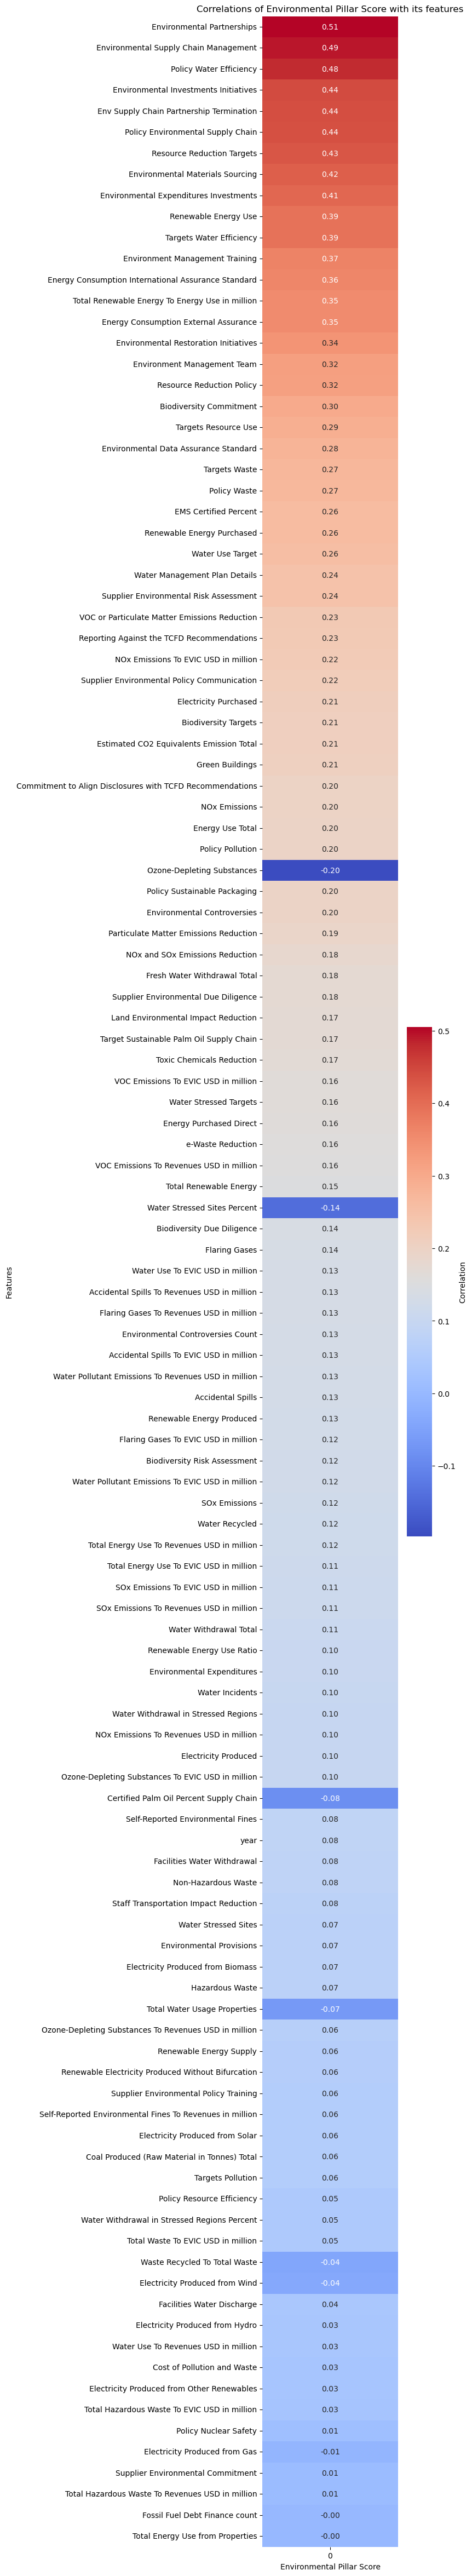


Top 10 features for Environmental Pillar Score:
Environmental Partnerships                  0.505200
Environmental Supply Chain Management       0.491863
Policy Water Efficiency                     0.479978
Environmental Investments Initiatives       0.442155
Env Supply Chain Partnership Termination    0.440357
Policy Environmental Supply Chain           0.438590
Resource Reduction Targets                  0.430717
Environmental Materials Sourcing            0.417717
Environmental Expenditures Investments      0.408947
Renewable Energy Use                        0.391621
dtype: float64


In [354]:
# ---- 1. Remove features with >90% missing values ----
missing_threshold = 0.9
keep_cols = [col for col in imputed_table.columns if imputed_table[col].isnull().mean() < missing_threshold]
filtered_table = imputed_table[keep_cols]

# ---- 2. Remove low-variance features ----
low_variance_cols = [col for col in filtered_table.columns if filtered_table[col].nunique(dropna=True) <= 1]
filtered_table = filtered_table.drop(columns=low_variance_cols)

# ---- 3. Prepare pillar-specific feature lists ----
gov_features = [col for col in governance if col in filtered_table.columns]
soc_features = [col for col in social if col in filtered_table.columns]
env_features = [col for col in environment if col in filtered_table.columns]

target_cols = {
    'Governance Pillar Score': gov_features,
    'Social Pillar Score': soc_features,
    'Environmental Pillar Score': env_features
}

corr_results = {}

for target, feats in target_cols.items():
    corr_dict = {}
    for feat in feats:
        # Only use numeric features
        if pd.api.types.is_numeric_dtype(filtered_table[feat]):
            valid = filtered_table[[feat, target]].dropna()
            if len(valid) > 2:
                corr_dict[feat] = valid[feat].corr(valid[target])
            else:
                corr_dict[feat] = np.nan
    corr_results[target] = pd.Series(corr_dict)

# ---- 4. Plot heatmap for each pillar ----
for target, corr_series in corr_results.items():
    sorted_corr = corr_series.dropna().sort_values(key=abs, ascending=False)
    plt.figure(figsize=(4, max(6, len(sorted_corr) // 2)))
    sns.heatmap(
        sorted_corr.values.reshape(-1, 1), 
        annot=True, fmt=".2f",
        yticklabels=sorted_corr.index, cmap='coolwarm',
        cbar_kws={'label': 'Correlation'}
    )
    plt.title(f"Correlations of {target} with its features")
    plt.ylabel('Features')
    plt.xlabel(target)
    plt.tight_layout()
    plt.show()
    # Print top features
    print(f"\nTop 10 features for {target}:")
    print(sorted_corr.head(10))


In [355]:
filtered_table

Audit Oversight of Tax  Named Position for Tax Oversight  \
0                       0.0                               0.0   
1                       0.0                               0.0   
2                       0.0                               0.0   
3                       0.0                               0.0   
4                       0.0                               0.0   
..                      ...                               ...   
514                     0.0                               0.0   
515                     0.0                               0.0   
516                     0.0                               0.0   
517                     0.0                               0.0   
518                     0.0                               0.0   

     Tax Breakdown by Country  Tax Breakdown by Domestic or International  \
0                         0.0                                         0.0   
1                         0.0                                         0.0   
2                         0.0                                         0.0   
3                         0.0                                         0.0   
4                         0.0                                         0.0   
..                        ...                                         ...   
514                       0.0                                         0.0   
515                       0.0                                         0.0   
516                       0.0                                         0.0   
517                       0.0                                         0.0   
518                       0.0                                         0.0   

     Tax Data Verification  Tax Fairness Commitment  Tax in Audit Tor  \
0                      0.0                      0.0               0.0   
1                      0.0                      0.0               0.0   
2                      0.0                      0.0               0.0   
3                      0.0                      0.0               0.0   
4                      0.0                      0.0               0.0   
..                     ...                      ...               ...   
514                    0.0                      0.0               0.0   
515                    0.0                      0.0               0.0   
516                    0.0                      0.0               0.0   
517                    0.0                      0.0               0.0   
518                    0.0                      0.0               0.0   

     Tax Oversight by Board  Policy Tax Transparency  Taxes Align to Revenues  \
0                       0.0                      0.0                      0.0   
1                       0.0                      0.0                      0.0   
2                       0.0                      0.0                      0.0   
3                       0.0                      0.0                      0.0   
4                       0.0                      0.0                      0.0   
..                      ...                      ...                      ...   
514                     0.0                      0.0                      0.0   
515                     0.0                      0.0                      0.0   
516                     0.0                      0.0                      0.0   
517                     0.0                      0.0                      0.0   
518                     0.0                      0.0                      0.0   

     ...  Critical Country 5_IR  Critical Country 5_nan  \
0    ...                      0                       1   
1    ...                      0                       1   
2    ...                      0                       1   
3    ...                      0                       1   
4    ...                      0                       1   
..   ...                    ...                     ...   
514  ...                      0     

In [356]:
numeric_cols = filtered_table.select_dtypes(include=[np.number]).columns

# Optionally, drop target columns if you only want feature-feature correlations
features_only = [col for col in numeric_cols if col not in target_cols.keys()]
# corr_matrix = imputed_table[features_only].corr()
# Or keep targets in the matrix:
corr_matrix = filtered_table[numeric_cols].corr()

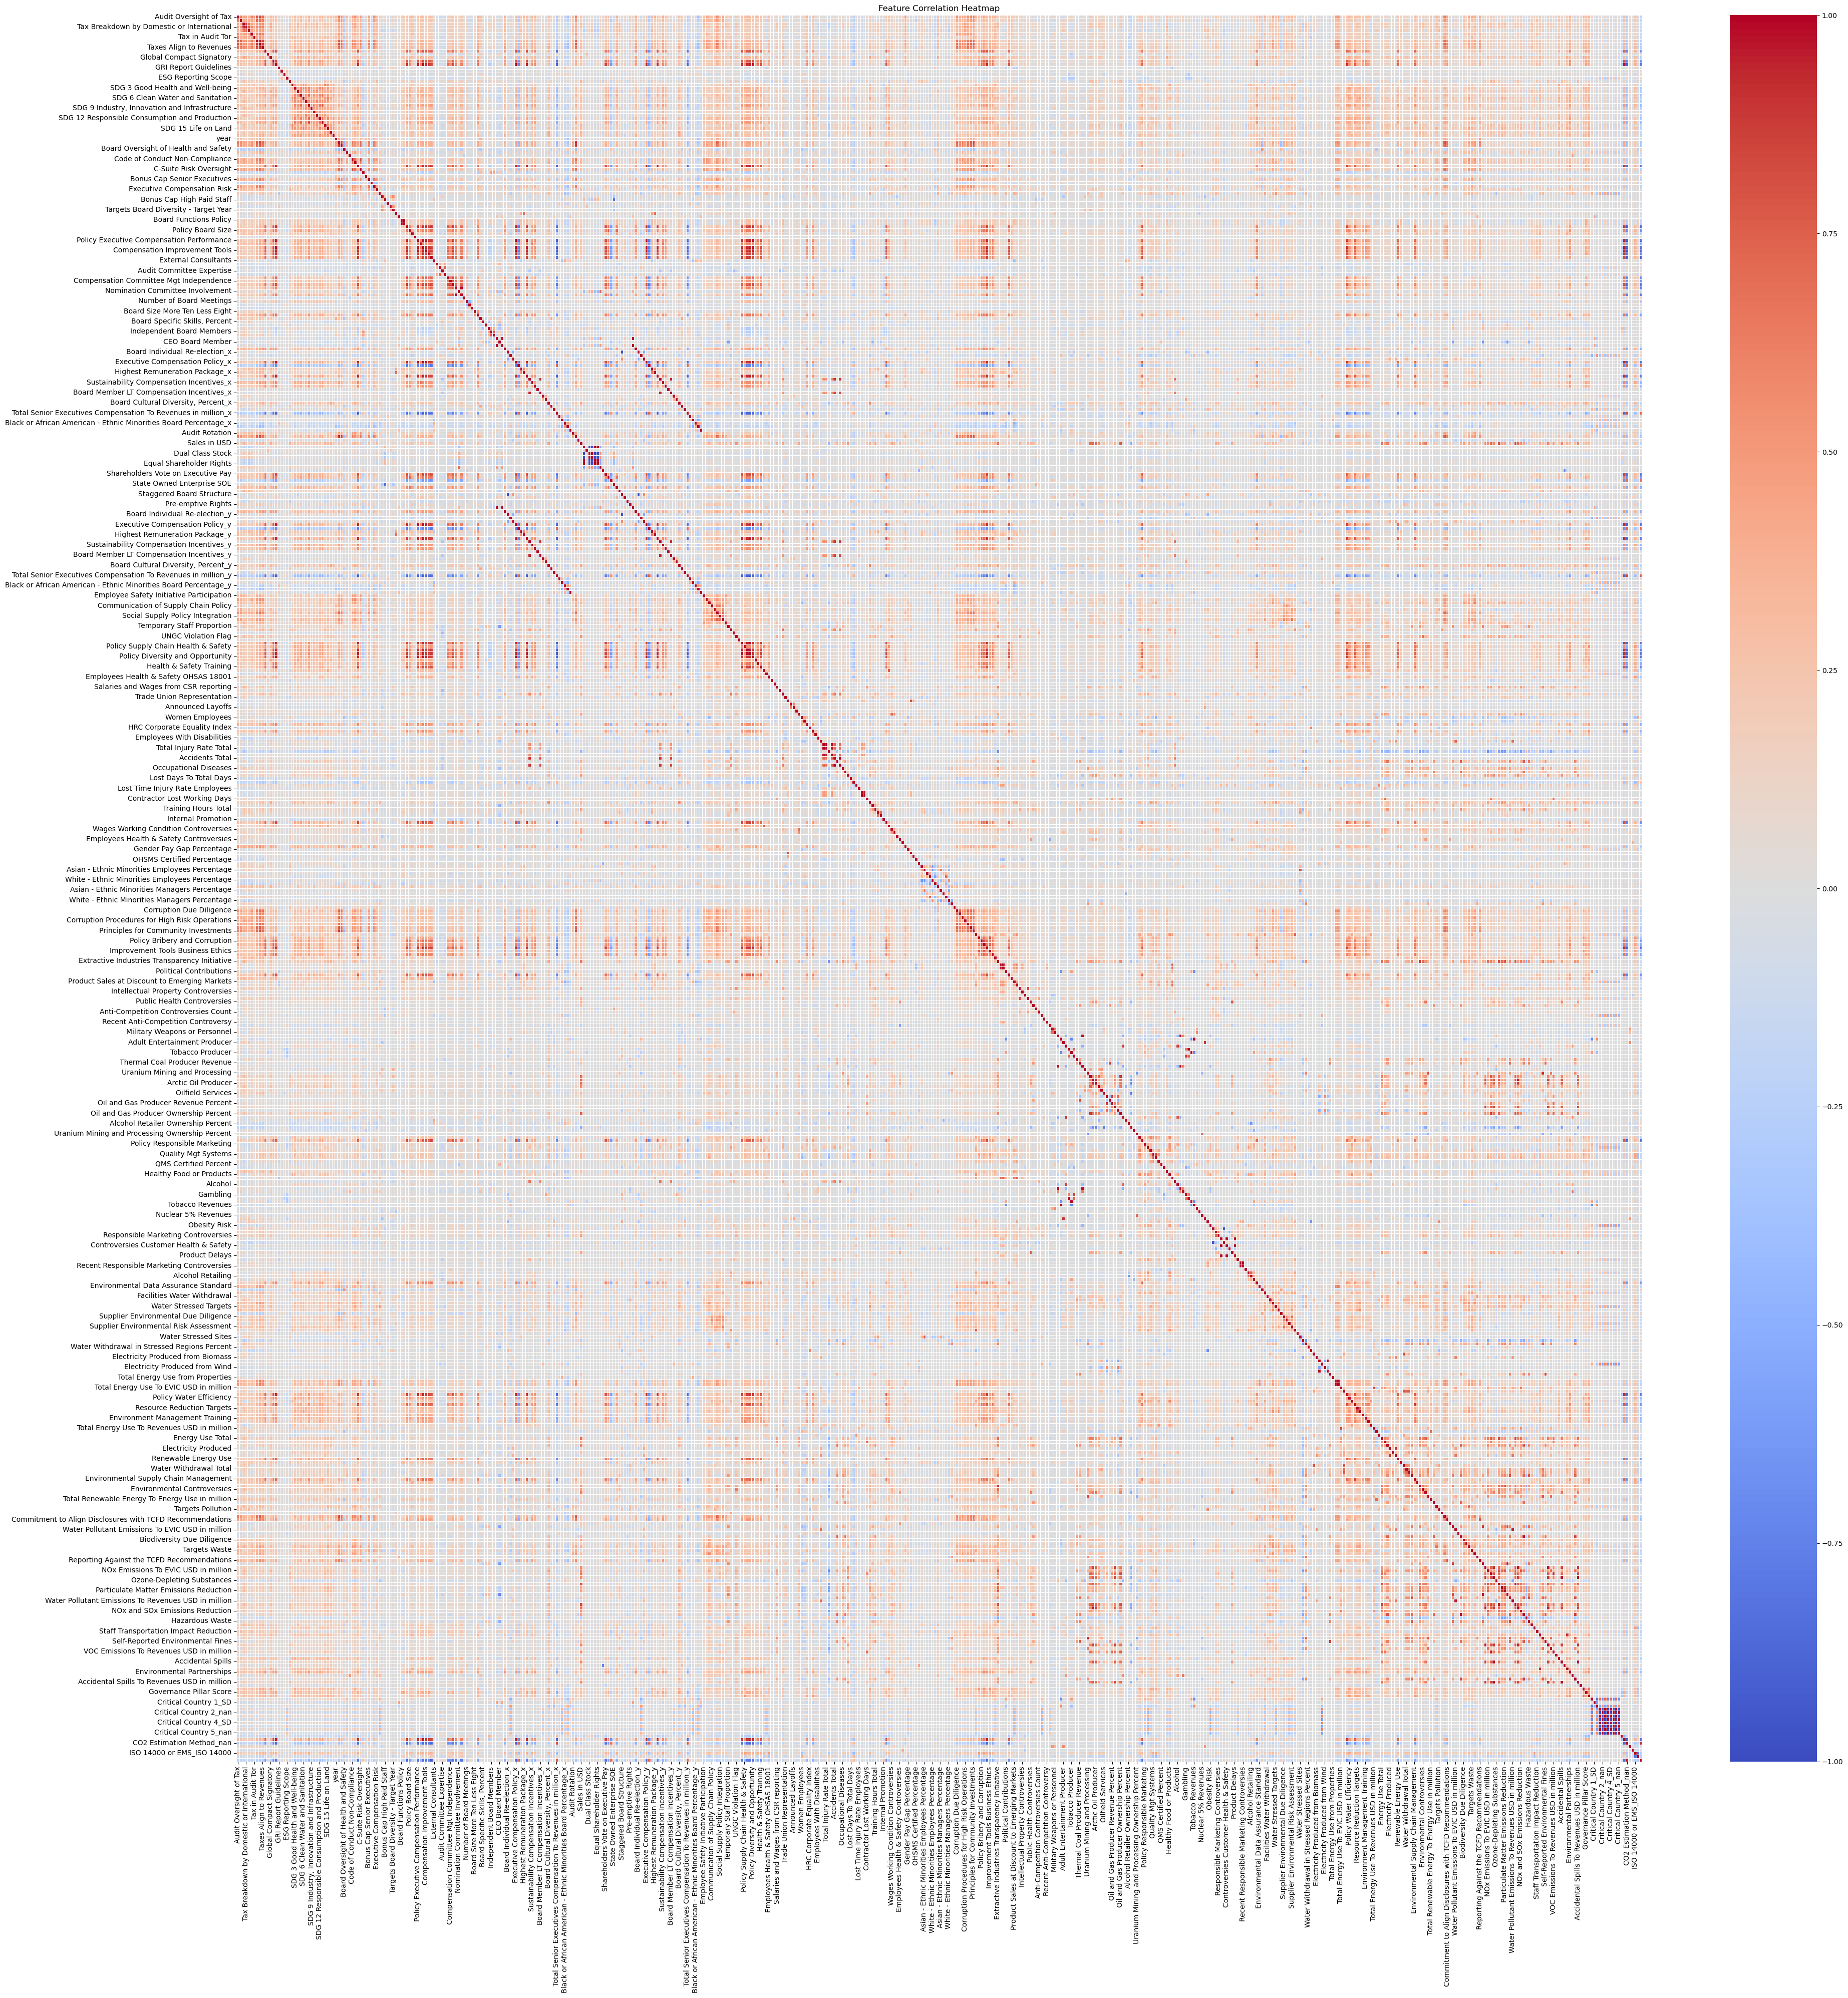

In [357]:
plt.figure(figsize=(min(40, len(numeric_cols)//2), min(40, len(numeric_cols)//2)))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0, linewidths=0.5)
plt.title('Feature Correlation Heatmap')
plt.tight_layout()
plt.show()


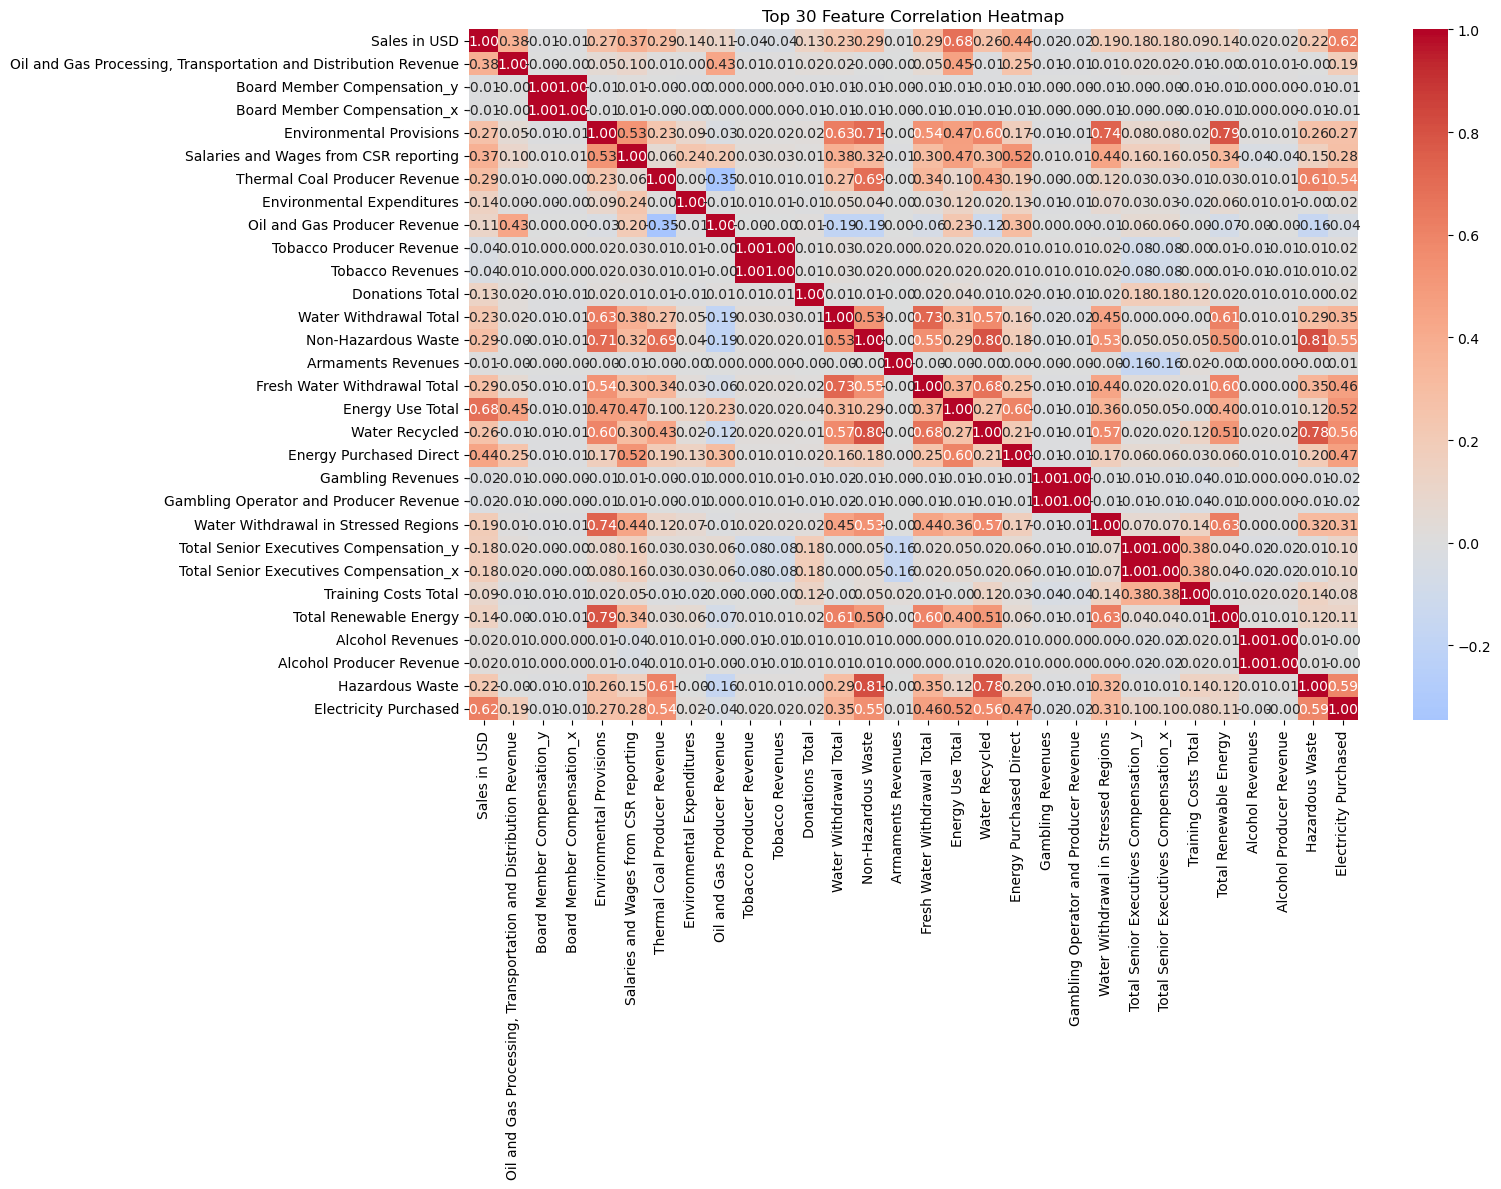

In [358]:
# Example: Plot only top 30 features by variance
top_n = 30
top_features = filtered_table[numeric_cols].var().sort_values(ascending=False).head(top_n).index
corr_matrix_top = filtered_table[top_features].corr()

plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix_top, annot=True, fmt='.2f', cmap='coolwarm', center=0)
plt.title('Top 30 Feature Correlation Heatmap')
plt.tight_layout()
plt.show()


In [359]:
filtered_table

Audit Oversight of Tax  Named Position for Tax Oversight  \
0                       0.0                               0.0   
1                       0.0                               0.0   
2                       0.0                               0.0   
3                       0.0                               0.0   
4                       0.0                               0.0   
..                      ...                               ...   
514                     0.0                               0.0   
515                     0.0                               0.0   
516                     0.0                               0.0   
517                     0.0                               0.0   
518                     0.0                               0.0   

     Tax Breakdown by Country  Tax Breakdown by Domestic or International  \
0                         0.0                                         0.0   
1                         0.0                                         0.0   
2                         0.0                                         0.0   
3                         0.0                                         0.0   
4                         0.0                                         0.0   
..                        ...                                         ...   
514                       0.0                                         0.0   
515                       0.0                                         0.0   
516                       0.0                                         0.0   
517                       0.0                                         0.0   
518                       0.0                                         0.0   

     Tax Data Verification  Tax Fairness Commitment  Tax in Audit Tor  \
0                      0.0                      0.0               0.0   
1                      0.0                      0.0               0.0   
2                      0.0                      0.0               0.0   
3                      0.0                      0.0               0.0   
4                      0.0                      0.0               0.0   
..                     ...                      ...               ...   
514                    0.0                      0.0               0.0   
515                    0.0                      0.0               0.0   
516                    0.0                      0.0               0.0   
517                    0.0                      0.0               0.0   
518                    0.0                      0.0               0.0   

     Tax Oversight by Board  Policy Tax Transparency  Taxes Align to Revenues  \
0                       0.0                      0.0                      0.0   
1                       0.0                      0.0                      0.0   
2                       0.0                      0.0                      0.0   
3                       0.0                      0.0                      0.0   
4                       0.0                      0.0                      0.0   
..                      ...                      ...                      ...   
514                     0.0                      0.0                      0.0   
515                     0.0                      0.0                      0.0   
516                     0.0                      0.0                      0.0   
517                     0.0                      0.0                      0.0   
518                     0.0                      0.0                      0.0   

     ...  Critical Country 5_IR  Critical Country 5_nan  \
0    ...                      0                       1   
1    ...                      0                       1   
2    ...                      0                       1   
3    ...                      0                       1   
4    ...                      0                       1   
..   ...                    ...                     ...   
514  ...                      0     

In [360]:
# Calculate the full correlation matrix
corr_matrix = filtered_table.select_dtypes(include=[np.number]).corr().abs()

# Set self-correlations to zero so we don't accidentally drop a feature for being "identical to itself"
np.fill_diagonal(corr_matrix.values, 0)

# Find columns with any correlation > 0.95
to_drop = set()
for col in corr_matrix.columns:
    # If this column is highly correlated with any later column, mark it for dropping
    high_corr = corr_matrix[col][corr_matrix[col] > 0.95].index
    to_drop.update(high_corr)

print(f"Dropping {len(to_drop)} highly correlated features:\n", to_drop)

reduced_table = filtered_table.drop(columns=to_drop)


Dropping 124 highly correlated features:
 {'NOx Emissions', 'White - Ethnic Minorities Board Percentage_x', 'Controversies Customer Health & Safety', 'Corporate Governance Board Committee', 'Executive Members Gender Diversity, Percent_y', 'Tobacco Producer Revenue', 'SOx Emissions', 'Energy Consumption International Assurance Standard', 'Board Member Term Duration_y', 'Flaring Gases To EVIC USD in million', 'Total Senior Executives Compensation_x', 'Compensation Improvement Tools', 'Policy Career Development', 'Alcohol Revenues', 'Executive Compensation Policy_y', 'Different Voting Right Share', 'SOx Emissions To EVIC USD in million', 'Total Senior Executives Compensation_y', 'Other - Ethnic Minorities Board Percentage_x', 'Black or African American - Ethnic Minorities Board Percentage_y', 'Tobacco Revenues', 'Donations Total', 'Mgt Compensation Controversies Count_y', 'Accidents Total', 'Critical Country 5_IR', 'Critical Country 2_nan', 'Dual Class Stock', 'Energy Consumption External

In [361]:
reduced_table

Audit Oversight of Tax  Named Position for Tax Oversight  \
0                       0.0                               0.0   
1                       0.0                               0.0   
2                       0.0                               0.0   
3                       0.0                               0.0   
4                       0.0                               0.0   
..                      ...                               ...   
514                     0.0                               0.0   
515                     0.0                               0.0   
516                     0.0                               0.0   
517                     0.0                               0.0   
518                     0.0                               0.0   

     Tax Breakdown by Country  Tax Breakdown by Domestic or International  \
0                         0.0                                         0.0   
1                         0.0                                         0.0   
2                         0.0                                         0.0   
3                         0.0                                         0.0   
4                         0.0                                         0.0   
..                        ...                                         ...   
514                       0.0                                         0.0   
515                       0.0                                         0.0   
516                       0.0                                         0.0   
517                       0.0                                         0.0   
518                       0.0                                         0.0   

     Tax Data Verification  Tax Fairness Commitment  Tax in Audit Tor  \
0                      0.0                      0.0               0.0   
1                      0.0                      0.0               0.0   
2                      0.0                      0.0               0.0   
3                      0.0                      0.0               0.0   
4                      0.0                      0.0               0.0   
..                     ...                      ...               ...   
514                    0.0                      0.0               0.0   
515                    0.0                      0.0               0.0   
516                    0.0                      0.0               0.0   
517                    0.0                      0.0               0.0   
518                    0.0                      0.0               0.0   

     Tax Oversight by Board  Policy Tax Transparency  Taxes Align to Revenues  \
0                       0.0                      0.0                      0.0   
1                       0.0                      0.0                      0.0   
2                       0.0                      0.0                      0.0   
3                       0.0                      0.0                      0.0   
4                       0.0                      0.0                      0.0   
..                      ...                      ...                      ...   
514                     0.0                      0.0                      0.0   
515                     0.0                      0.0                      0.0   
516                     0.0                      0.0                      0.0   
517                     0.0                      0.0                      0.0   
518                     0.0                      0.0                      0.0   

     ...  Critical Country 1_CU  Critical Country 1_SD  \
0    ...                      0                      0   
1    ...                      0                      0   
2    ...                      0                      0   
3    ...                      0                      0   
4    ...                      0                      0   
..   ...                    ...                    ...   
514  ...                      0            

In [363]:
reduced_table.describe()

Audit Oversight of Tax  Named Position for Tax Oversight  \
count              519.000000                        519.000000   
mean                 0.375723                          0.296724   
std                  0.484776                          0.457255   
min                  0.000000                          0.000000   
25%                  0.000000                          0.000000   
50%                  0.000000                          0.000000   
75%                  1.000000                          1.000000   
max                  1.000000                          1.000000   

       Tax Breakdown by Country  Tax Breakdown by Domestic or International  \
count                519.000000                                  519.000000   
mean                   0.208092                                    0.238921   
std                    0.406335                                    0.426836   
min                    0.000000                                    0.000000   
25%                    0.000000                                    0.000000   
50%                    0.000000                                    0.000000   
75%                    0.000000                                    0.000000   
max                    1.000000                                    1.000000   

       Tax Data Verification  Tax Fairness Commitment  Tax in Audit Tor  \
count             519.000000               519.000000        519.000000   
mean                0.148362                 0.269750          0.157996   
std                 0.355802                 0.444258          0.365089   
min                 0.000000                 0.000000          0.000000   
25%                 0.000000                 0.000000          0.000000   
50%                 0.000000                 0.000000          0.000000   
75%                 0.000000                 1.000000          0.000000   
max                 1.000000                 1.000000          1.000000   

       Tax Oversight by Board  Policy Tax Transparency  \
count              519.000000               519.000000   
mean                 0.448940                 0.485549   
std                  0.497866                 0.500273   
min                  0.000000                 0.000000   
25%                  0.000000                 0.000000   
50%                  0.000000                 0.000000   
75%                  1.000000                 1.000000   
max                  1.000000                 1.000000   

       Taxes Align to Revenues  ...  Critical Country 1_CU  \
count               519.000000  ...             519.000000   
mean                  0.406551  ...               0.019268   
std                   0.491664  ...               0.137597   
min                   0.000000  ...               0.000000   
25%                   0.000000  ...               0.000000   
50%                   0.000000  ...               0.000000   
75%                   1.000000  ...               0.000000   
max                   1.000000  ...               1.000000   

       Critical Country 1_SD  Critical Country 1_nan  \
count             519.000000              519.000000   
mean                0.009634                0.971098   
std                 0.097773                0.167692   
min                 0.000000                0.000000   
25%                 0.000000                1.000000   
50%                 0.000000                1.000000   
75%                 0.000000                1.000000   
max                 1.000000                1.000000   

       CO2 Estimation Method_Median  CO2 Estimation Method_nan  \
count                    519.000000                 519.000000   
mean                       0.025048                   0.096339   
std                        0.156422                   0.295340   
min                        0.000000                   0.000000   
25%                        0.000000                   0.000000   
50%                        0.000

In [ ]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

LinearRegressionGov: Test R2 = 0.585, Test RMSE = 12.382
RidgeGov: Test R2 = 0.659, Test RMSE = 11.232
LassoGov: Test R2 = 0.420, Test RMSE = 14.634


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=1.41826e-24): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


RandomForestGov: Test R2 = 0.726, Test RMSE = 10.059
XGBoostGov: Test R2 = 0.773, Test RMSE = 9.149


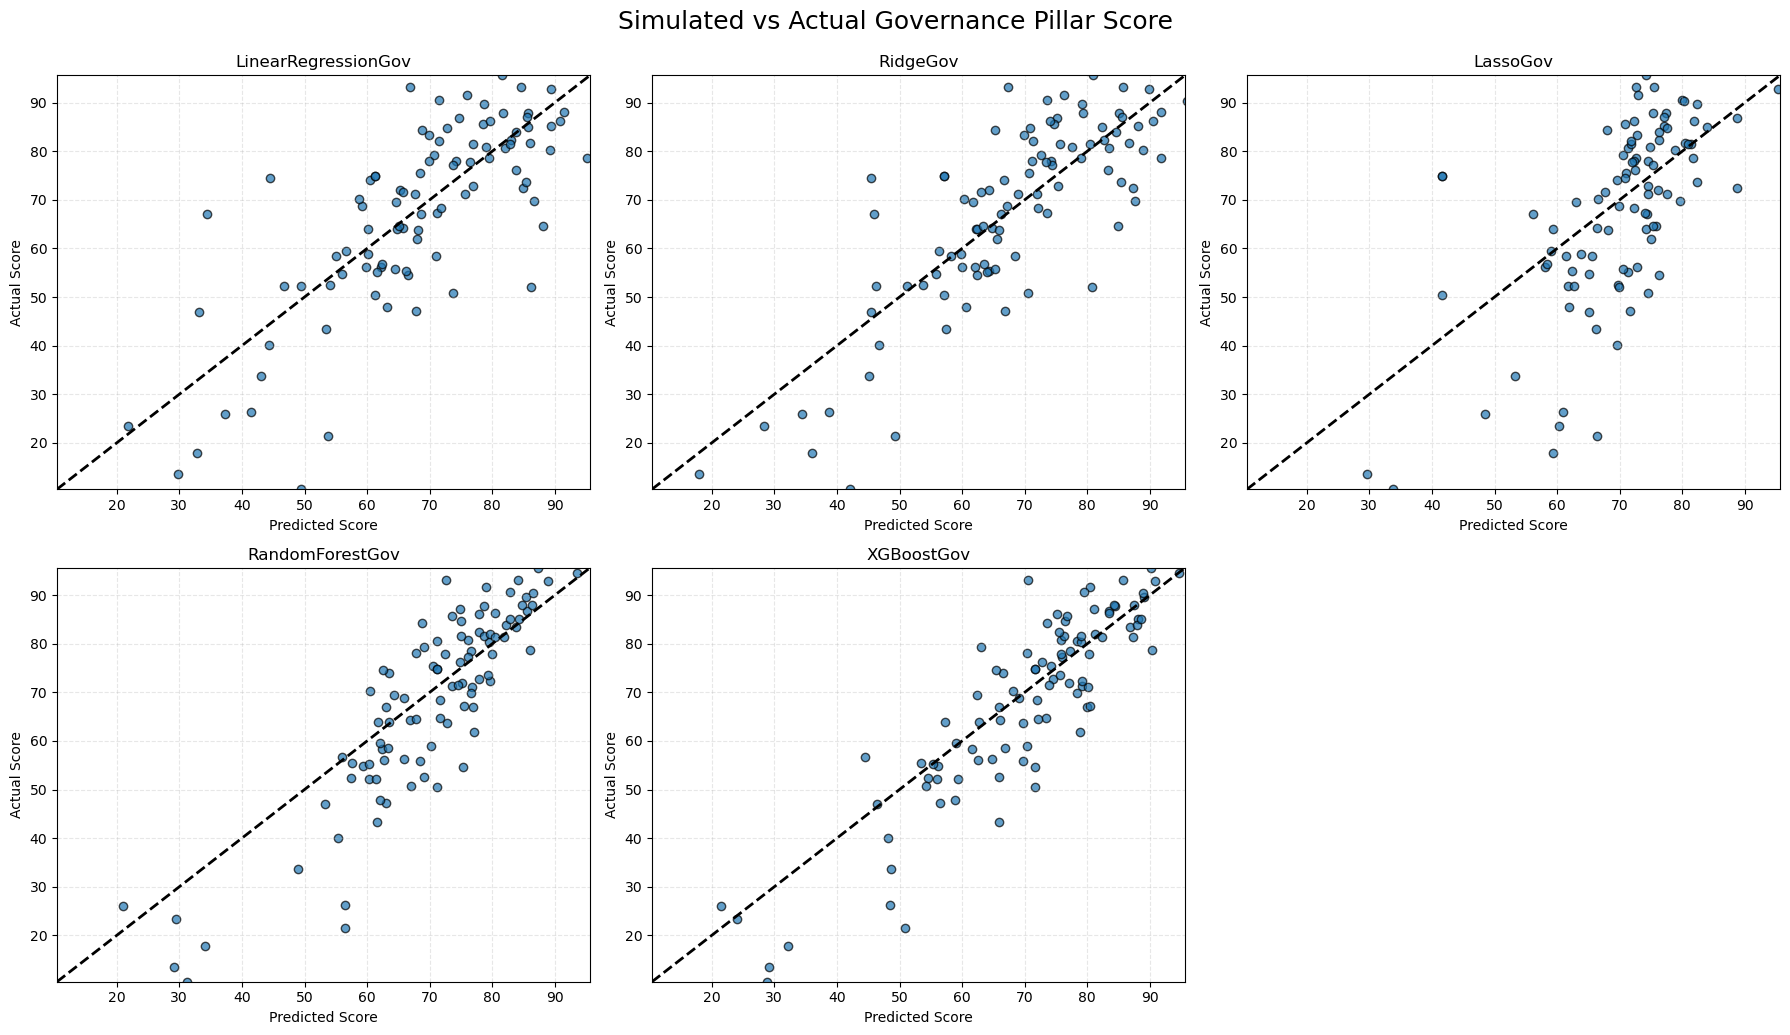

In [ ]:
models_test_gov = {
    "LinearRegressionGov": LinearRegression(),
    "RidgeGov": Ridge(random_state=42),
    "LassoGov": Lasso(random_state=42),
    "RandomForestGov": RandomForestRegressor(random_state=42),
    "XGBoostGov": XGBRegressor(random_state=42, n_estimators=500, learning_rate=0.05)
}

# columns present in reduced_table
gov_cols_in_table = [c for c in gov_cols if c in reduced_table.columns]

# build X, y
X_gov = reduced_table[gov_cols_in_table].copy()
y_gov = reduced_table["Governance Pillar Score"].copy()

# drop rows where y is NaN
mask = y_gov.notnull()
X_gov = X_gov.loc[mask]
y_gov = y_gov.loc[mask]

# extra guard: drop target if it somehow appears in X_gov
if "Governance Pillar Score" in X_gov.columns:
    X_gov = X_gov.drop(columns=["Governance Pillar Score"])

X_gov_train, X_gov_test, y_gov_train, y_gov_test = train_test_split(
    X_gov, y_gov, test_size=0.2, random_state=42
)

model_preds_gov = {}
metrics_gov = {}

for name, model in models_test_gov.items():
    model.fit(X_gov_train, y_gov_train)                         # FIX 1
    y_pred_gov = model.predict(X_gov_test)
    r2 = r2_score(y_gov_test, y_pred_gov)                       # FIX 2
    rmse = np.sqrt(mean_squared_error(y_gov_test, y_pred_gov))
    metrics_gov[name] = {"R2": r2, "RMSE": rmse}
    model_preds_gov[name] = y_pred_gov                          # FIX 3
    print(f"{name}: Test R2 = {r2:.3f}, Test RMSE = {rmse:.3f}")

# plot
plt.figure(figsize=(18, 10))
for i, (name, y_pred_gov) in enumerate(model_preds_gov.items(), start=1):
    plt.subplot(2, 3, i)
    plt.scatter(y_pred_gov, y_gov_test, alpha=0.7, edgecolor='k')
    lo, hi = y_gov_test.min(), y_gov_test.max()
    plt.plot([lo, hi], [lo, hi], 'k--', lw=2)
    plt.xlabel('Predicted Score')
    plt.ylabel('Actual Score')
    plt.title(name)
    plt.xlim(lo, hi)
    plt.ylim(lo, hi)
    plt.grid(True, linestyle='--', alpha=0.3)

plt.tight_layout()
plt.suptitle("Simulated vs Actual Governance Pillar Score", fontsize=18, y=1.03)
plt.show()


LinearRegressionSoc: Test R2 = 0.555, Test RMSE = 12.023
RidgeSoc: Test R2 = 0.612, Test RMSE = 11.229
LassoSoc: Test R2 = 0.453, Test RMSE = 13.333


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=4.05858e-24): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


RandomForestSoc: Test R2 = 0.829, Test RMSE = 7.459
XGBoostSoc: Test R2 = 0.812, Test RMSE = 7.818


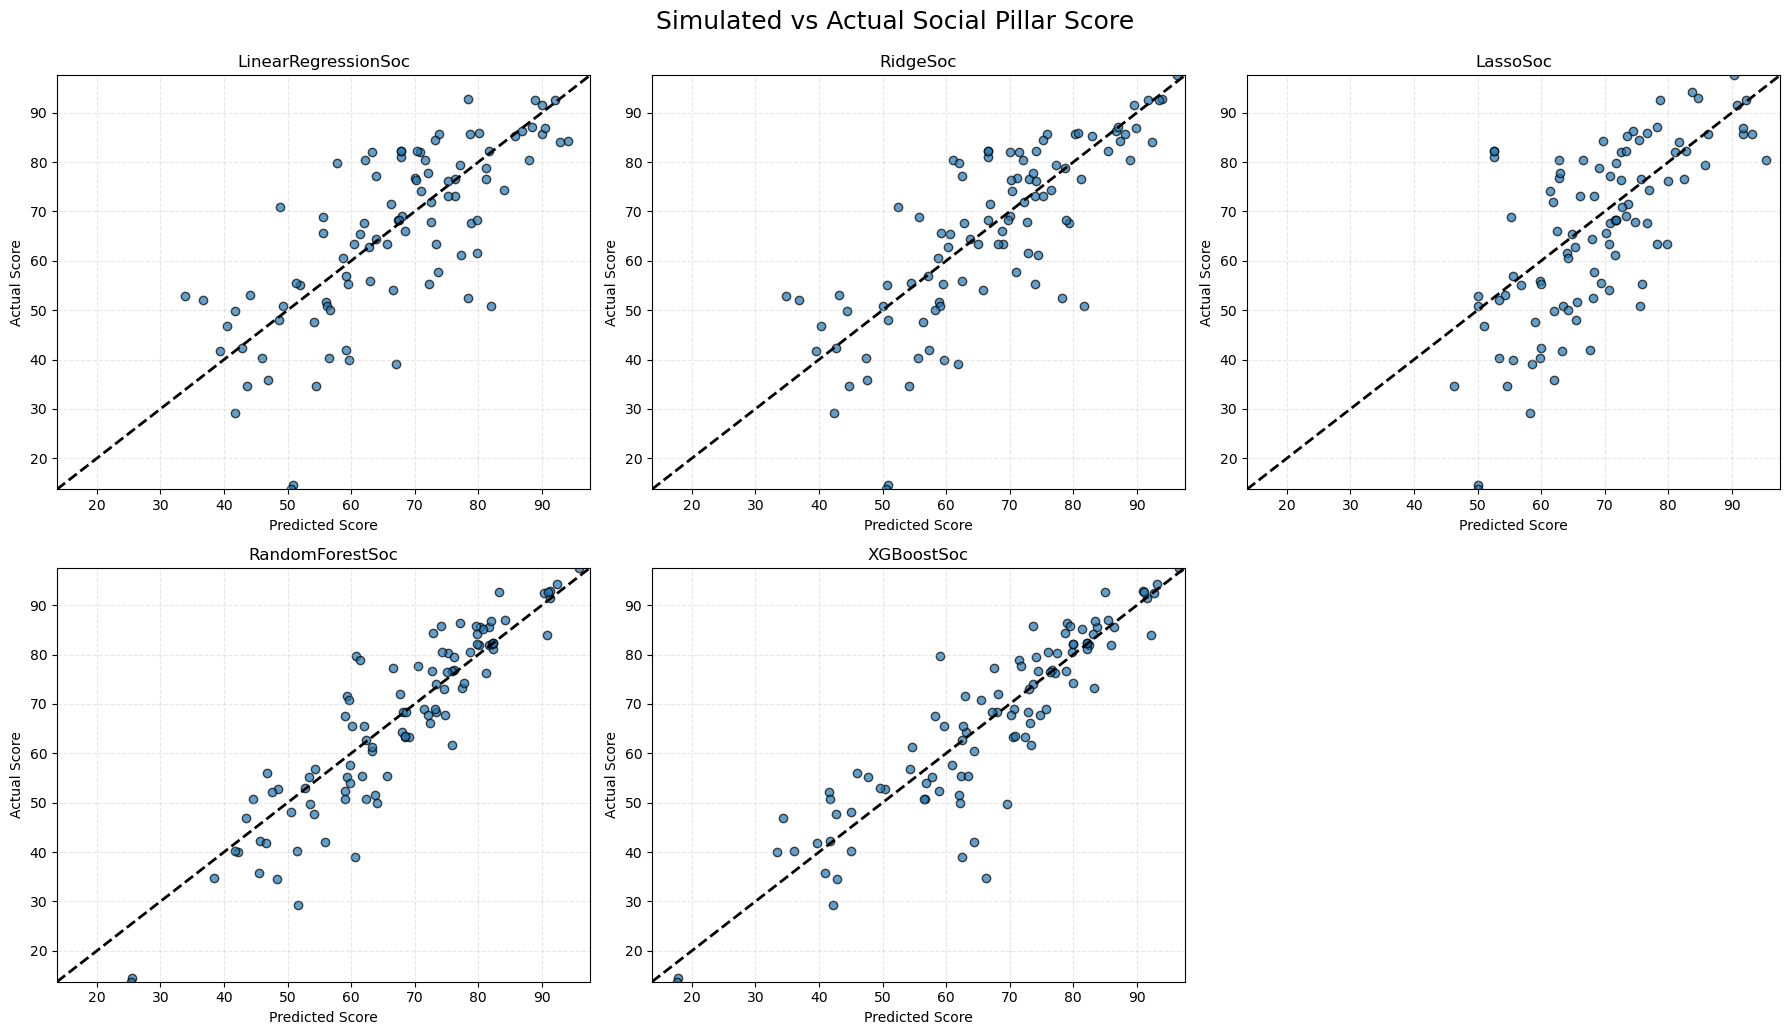

In [562]:
models_test_soc = {
    "LinearRegressionSoc": LinearRegression(),
    "RidgeSoc": Ridge(random_state=42),
    "LassoSoc": Lasso(random_state=42),
    "RandomForestSoc": RandomForestRegressor(random_state=42),
    "XGBoostSoc": XGBRegressor(random_state=42, n_estimators=500, learning_rate=0.05)
}

# columns present in reduced_table
soc_cols_in_table = [c for c in soc_cols if c in reduced_table.columns]

# build X, y
X_soc = reduced_table[soc_cols_in_table].copy()
y_soc = reduced_table["Social Pillar Score"].copy()

# drop rows where y is NaN
mask = y_soc.notnull()
X_soc = X_soc.loc[mask]
y_soc = y_soc.loc[mask]

# extra guard: drop target if it somehow appears in X_soc
if "Social Pillar Score" in X_soc.columns:
    X_soc = X_soc.drop(columns=["Social Pillar Score"])

X_soc_train, X_soc_test, y_soc_train, y_soc_test = train_test_split(
    X_soc, y_soc, test_size=0.2, random_state=42
)

model_preds_soc = {}
metrics_soc = {}

for name, model in models_test_soc.items():
    model.fit(X_soc_train, y_soc_train)
    y_pred_soc = model.predict(X_soc_test)
    r2 = r2_score(y_soc_test, y_pred_soc)
    rmse = np.sqrt(mean_squared_error(y_soc_test, y_pred_soc))
    metrics_soc[name] = {"R2": r2, "RMSE": rmse}
    model_preds_soc[name] = y_pred_soc
    print(f"{name}: Test R2 = {r2:.3f}, Test RMSE = {rmse:.3f}")

# plot
plt.figure(figsize=(18, 10))
for i, (name, y_pred_soc) in enumerate(model_preds_soc.items(), start=1):
    plt.subplot(2, 3, i)
    plt.scatter(y_pred_soc, y_soc_test, alpha=0.7, edgecolor='k')
    lo, hi = y_soc_test.min(), y_soc_test.max()
    plt.plot([lo, hi], [lo, hi], 'k--', lw=2)
    plt.xlabel('Predicted Score')
    plt.ylabel('Actual Score')
    plt.title(name)
    plt.xlim(lo, hi)
    plt.ylim(lo, hi)
    plt.grid(True, linestyle='--', alpha=0.3)

plt.tight_layout()
plt.suptitle("Simulated vs Actual Social Pillar Score", fontsize=18, y=1.03)
plt.show()


LinearRegressionEnv: Test R2 = 0.281, Test RMSE = 20.154
RidgeEnv: Test R2 = 0.327, Test RMSE = 19.494
LassoEnv: Test R2 = 0.361, Test RMSE = 19.000


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=5.39331e-22): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.571e+04, tolerance: 1.861e+01
  model = cd_fast.enet_coordinate_descent(


RandomForestEnv: Test R2 = 0.722, Test RMSE = 12.530
XGBoostEnv: Test R2 = 0.781, Test RMSE = 11.123


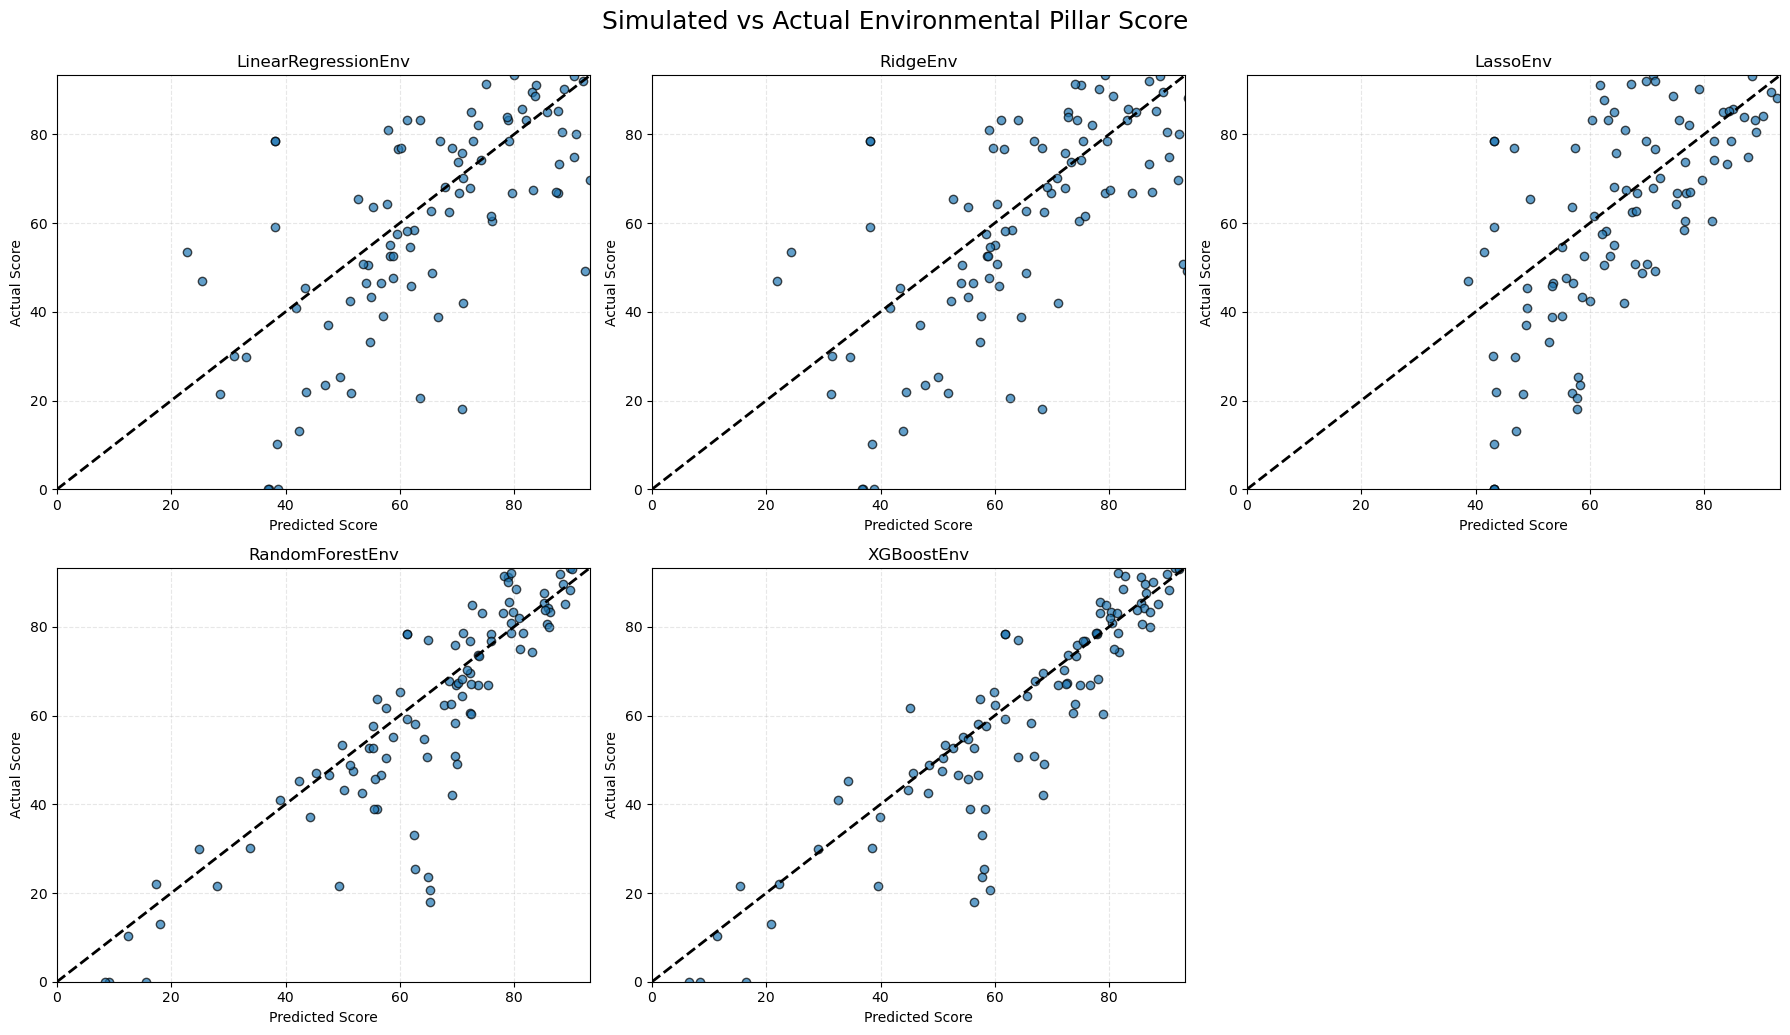

In [563]:
models_test_env = {
    "LinearRegressionEnv": LinearRegression(),
    "RidgeEnv": Ridge(random_state=42),
    "LassoEnv": Lasso(random_state=42),
    "RandomForestEnv": RandomForestRegressor(random_state=42),
    "XGBoostEnv": XGBRegressor(random_state=42, n_estimators=500, learning_rate=0.05)
}

# columns present in reduced_table
env_cols_in_table = [c for c in env_cols if c in reduced_table.columns]

# build X, y
X_env = reduced_table[env_cols_in_table].copy()
y_env = reduced_table["Environmental Pillar Score"].copy()

# drop rows where y is NaN
mask = y_env.notnull()
X_env = X_env.loc[mask]
y_env = y_env.loc[mask]

# extra guard: drop target if it somehow appears in X_env
if "Environmental Pillar Score" in X_env.columns:
    X_env = X_env.drop(columns=["Environmental Pillar Score"])

X_env_train, X_env_test, y_env_train, y_env_test = train_test_split(
    X_env, y_env, test_size=0.2, random_state=42
)

model_preds_env = {}
metrics_env = {}

for name, model in models_test_env.items():
    model.fit(X_env_train, y_env_train)
    y_pred_env = model.predict(X_env_test)
    r2 = r2_score(y_env_test, y_pred_env)
    rmse = np.sqrt(mean_squared_error(y_env_test, y_pred_env))
    metrics_env[name] = {"R2": r2, "RMSE": rmse}
    model_preds_env[name] = y_pred_env
    print(f"{name}: Test R2 = {r2:.3f}, Test RMSE = {rmse:.3f}")

# plot
plt.figure(figsize=(18, 10))
for i, (name, y_pred_env) in enumerate(model_preds_env.items(), start=1):
    plt.subplot(2, 3, i)
    plt.scatter(y_pred_env, y_env_test, alpha=0.7, edgecolor='k')
    lo, hi = y_env_test.min(), y_env_test.max()
    plt.plot([lo, hi], [lo, hi], 'k--', lw=2)
    plt.xlabel('Predicted Score')
    plt.ylabel('Actual Score')
    plt.title(name)
    plt.xlim(lo, hi)
    plt.ylim(lo, hi)
    plt.grid(True, linestyle='--', alpha=0.3)

plt.tight_layout()
plt.suptitle("Simulated vs Actual Environmental Pillar Score", fontsize=18, y=1.03)
plt.show()



Explaining model: RandomForestGov


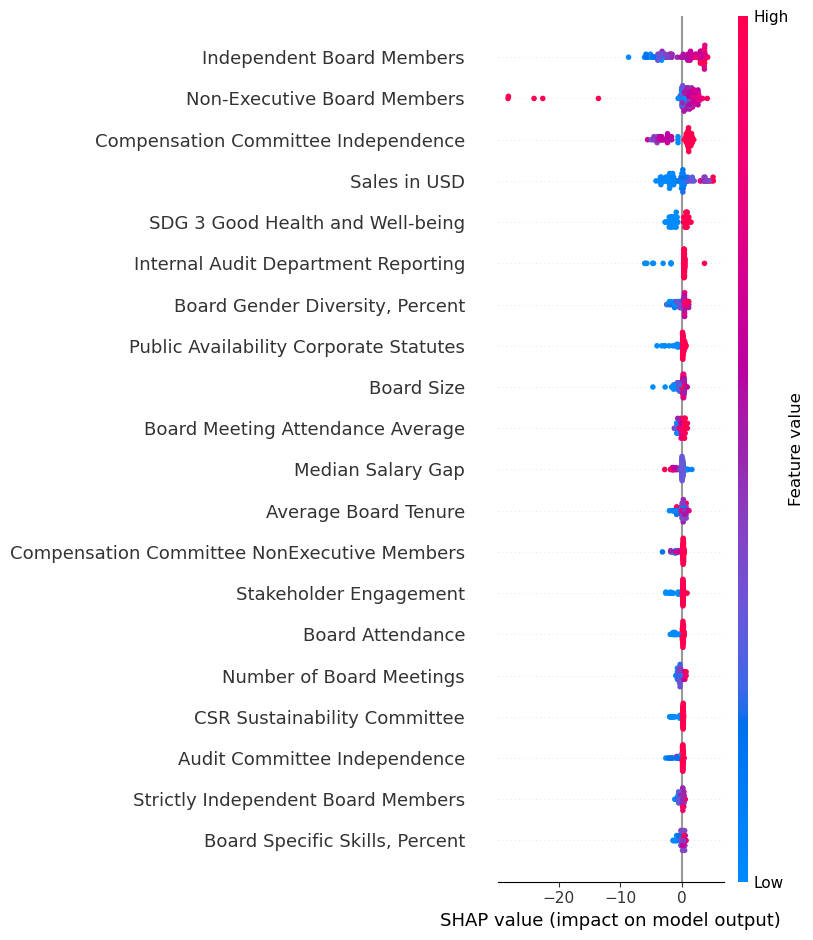

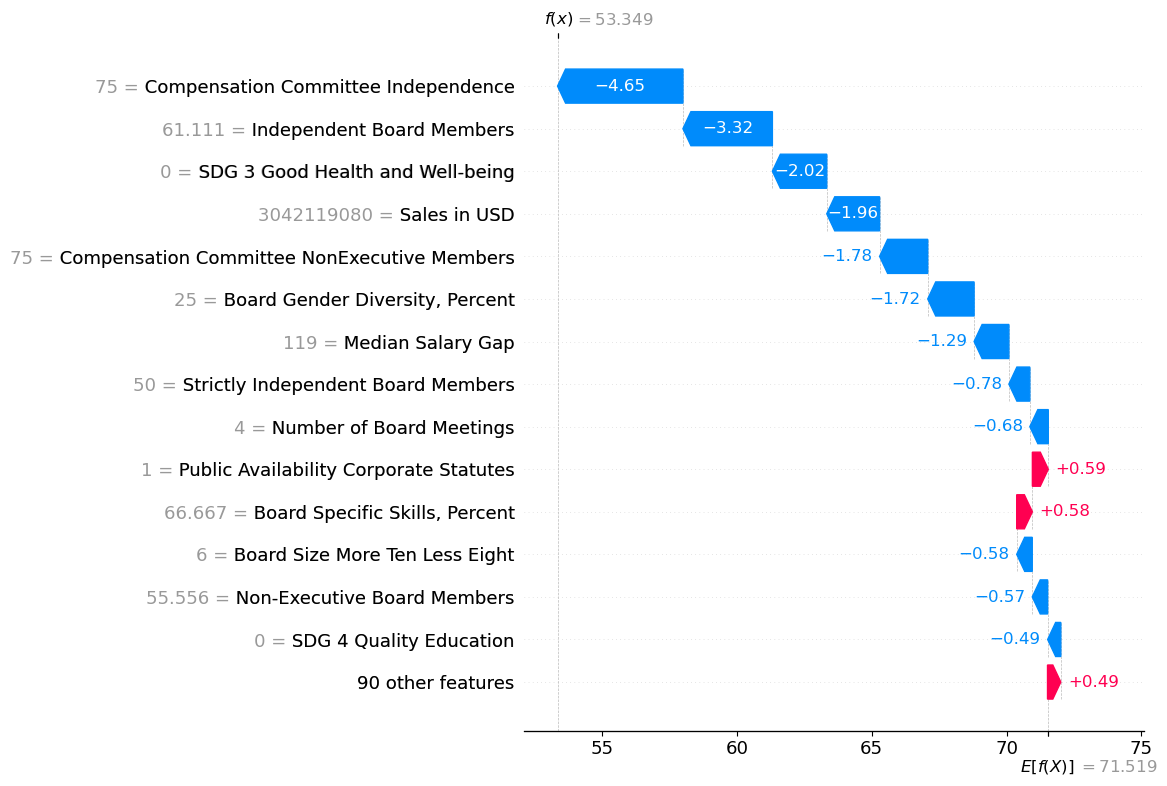


Explaining model: XGBoostGov


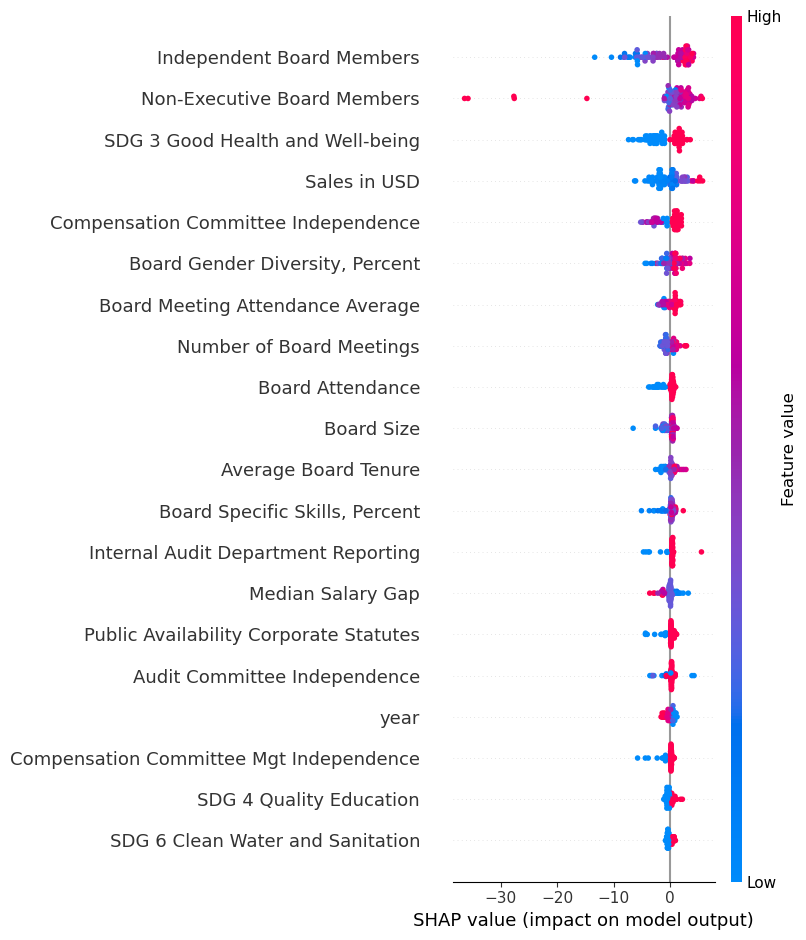

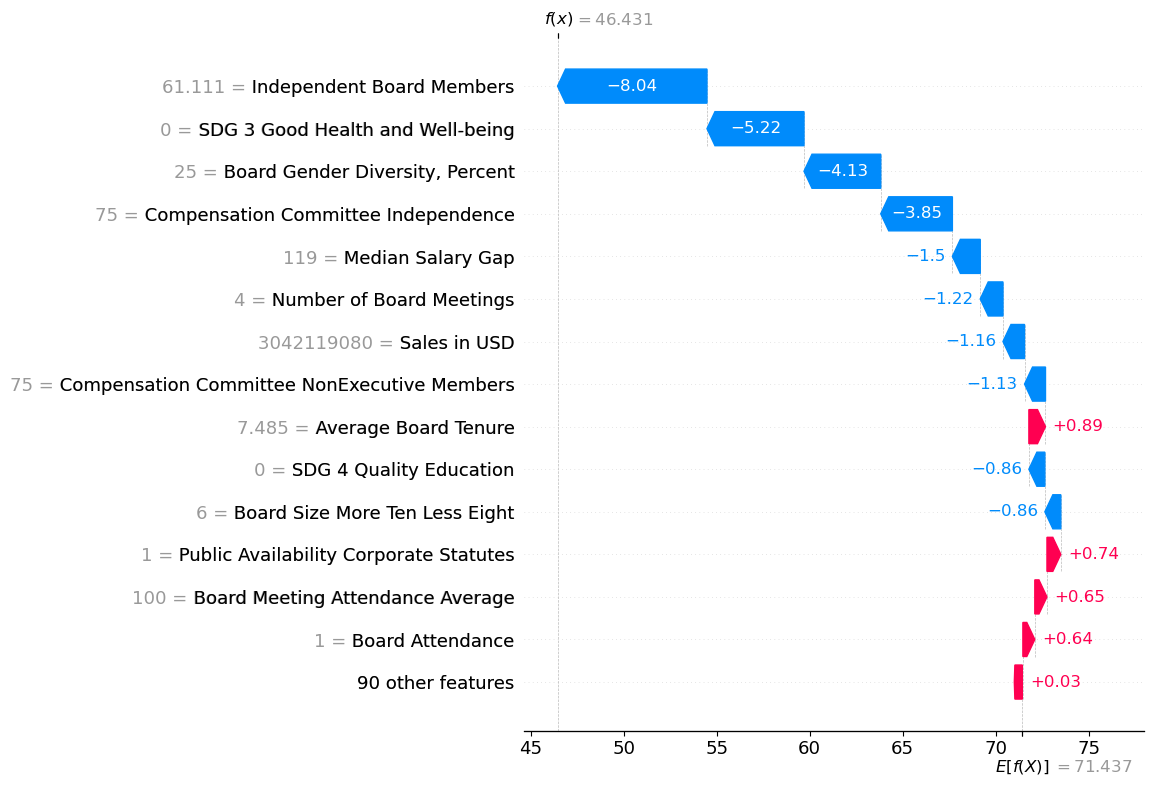

In [571]:
import shap
import numpy as np

# Data to explain
X_explain_gov = X_gov_test.copy()
feature_names = X_explain_gov.columns.tolist()

# Restrict to SHAP-compatible models (tree-based in your case)
shap_models = {
    name: model 
    for name, model in models_test_gov.items()
    if isinstance(model, (RandomForestRegressor, XGBRegressor))
}

for name, model in shap_models.items():
    print(f"\nExplaining model: {name}")

    # Tree-based explainer
    explainer_gov = shap.TreeExplainer(model)
    shap_values = explainer_gov(X_explain_gov)

    # Global feature importance
    shap.summary_plot(shap_values, X_explain_gov, plot_type="dot", show=True)

    # Local explanation for first test sample
    shap.plots.waterfall(
        shap.Explanation(
            values=shap_values.values[0],
            base_values=shap_values.base_values[0] if np.ndim(shap_values.base_values) > 0 else shap_values.base_values,
            data=X_explain_gov.iloc[0].values,
            feature_names=feature_names
        ),
        max_display=15,
        show=True
    )



Explaining model: RandomForestSoc


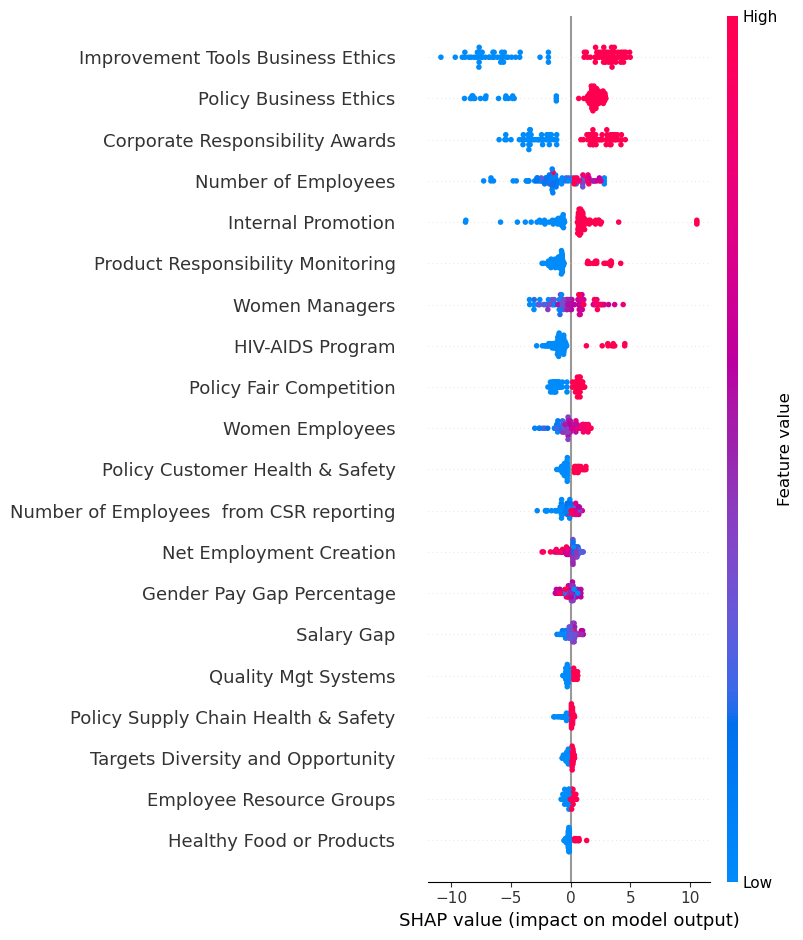

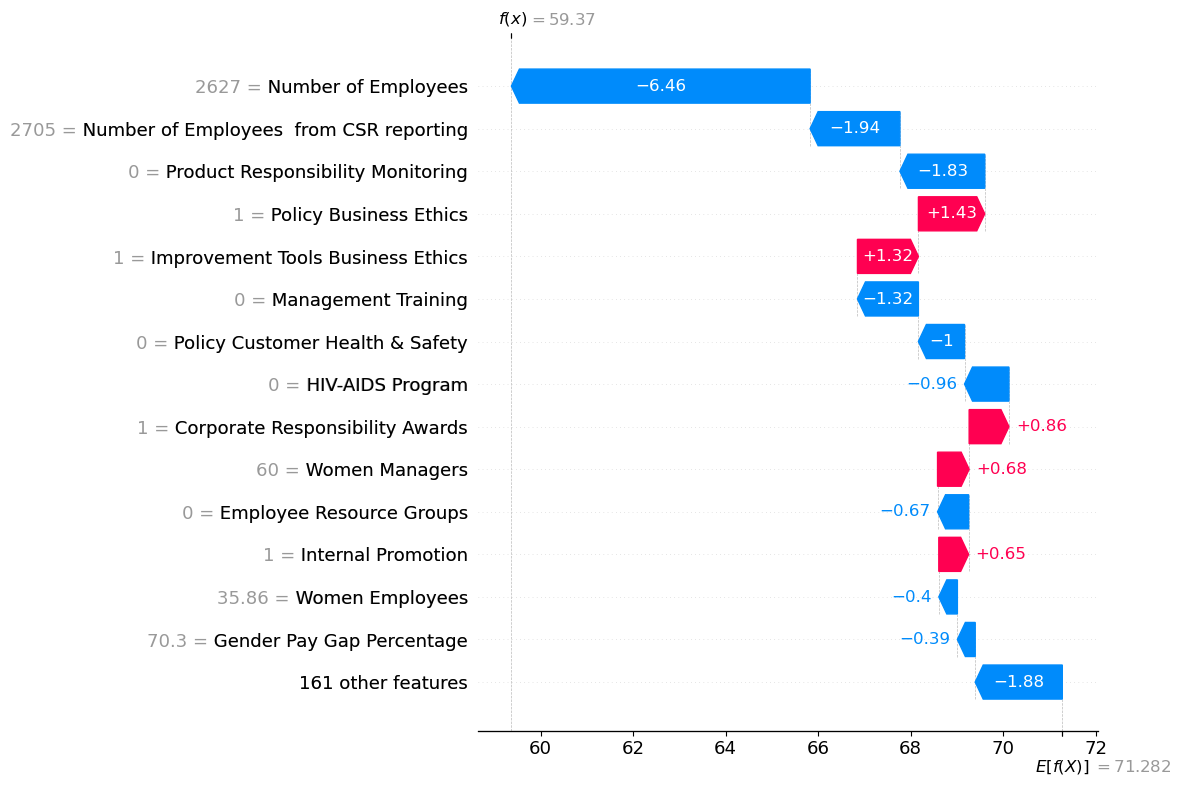


Explaining model: XGBoostSoc


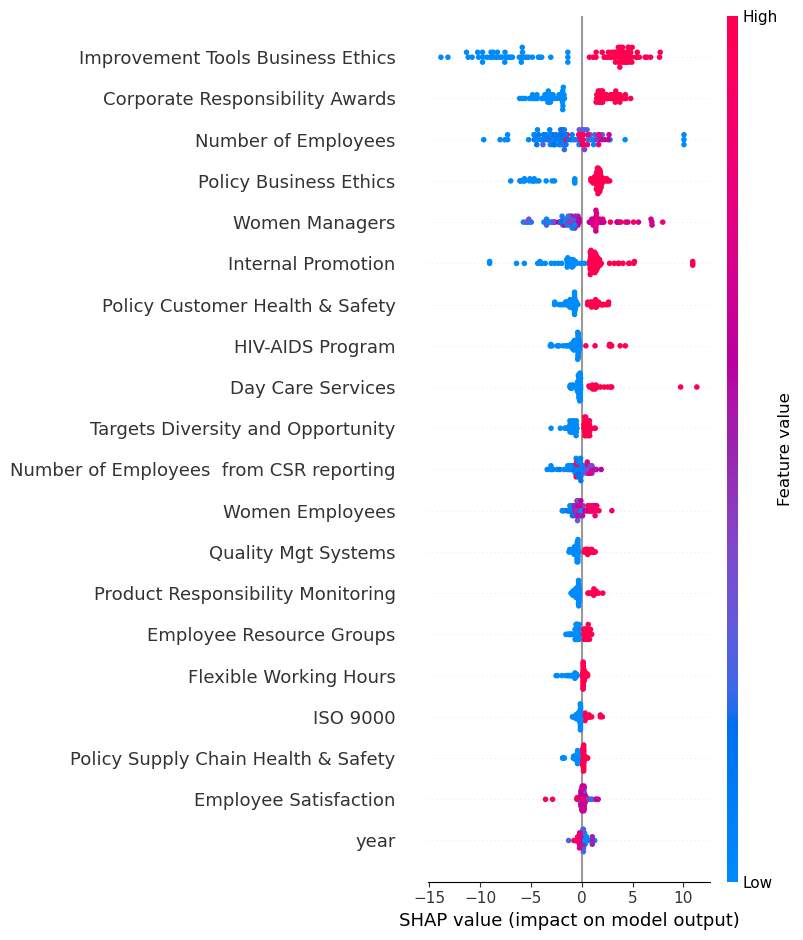

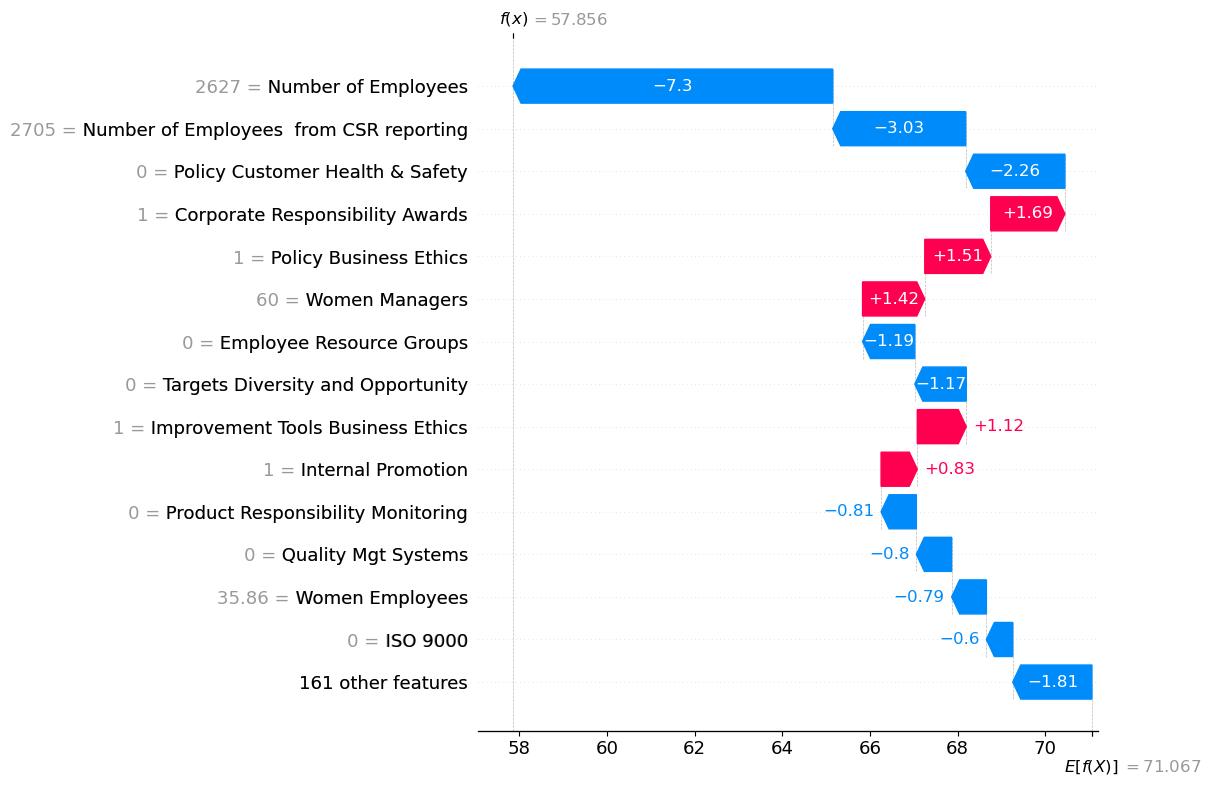

In [572]:
import shap
import numpy as np

# Data to explain
X_explain_soc = X_soc_test.copy()
feature_names = X_explain_soc.columns.tolist()

# Restrict to SHAP-compatible models (tree-based in your case)
shap_models = {
    name: model 
    for name, model in models_test_soc.items()
    if isinstance(model, (RandomForestRegressor, XGBRegressor))
}

for name, model in shap_models.items():
    print(f"\nExplaining model: {name}")

    # Tree-based explainer
    explainer_soc = shap.TreeExplainer(model)
    shap_values = explainer_soc(X_explain_soc)

    # Global feature importance
    shap.summary_plot(shap_values, X_explain_soc, plot_type="dot", show=True)

    # Local explanation for first test sample
    shap.plots.waterfall(
        shap.Explanation(
            values=shap_values.values[0],
            base_values=shap_values.base_values[0] if np.ndim(shap_values.base_values) > 0 else shap_values.base_values,
            data=X_explain_soc.iloc[0].values,
            feature_names=feature_names
        ),
        max_display=15,
        show=True
    )
